## Can You Make Buying Life Insurance Easier?

In 2015, Prudential (large life insurance company) issued a challenge to Data Scientists to help predict which 'type' of life insurance a particular applicant would be expected to get. It was found that due to lengthy process of analyzing customer data before returning a result (weeks!), only 40% of all US households owned life insurance. The goal of creating a machine learning model in this case is necessary to make the whole process more efficient, profitable, and less painful for prospective customers.

The Prudential Life Insurance Dataset has ~80000 rows and 127 columns. The target class consists of integers that range from 1 - 8. It is unknown if these are ordinal or nominal.

## Columns

- id - Unique identifier for application
- Product Info (1-7) - Normalized variables WRT to product applied for
- Ins_Age - Normalized age for applicant
- Ht - Normalized ht for applicant 
- BMI - Normalized BMI for applicant 
- Employement Info (1-6) - Normalized variables wrt to employment history of applicant 
- Insured Info (1-7) - Normalized variables wrt to (?) of applicant 
- Insurance History (1-9) - Normalized variables relating to insurance history of applicant 
- Family Hist (1-5) - Normalized Variables wrt family history of applicant 
- Medical History (1-41) - Normalized variables relating to medical history of applicant 
- Medical Keyword (1-48) - Dumy variables relating to presence of a medical keyword in the application

It is of note that every single column has been normalized already prior to analysis.

In [1]:
# General imports 
import os

# Data analytic/viz Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline
import seaborn as sns

# ML imports 
from sklearn.decomposition import PCA

# Not saving this in my google drive sync
os.chdir('G:/GDrive/WCD/Week 09 - Projects/Prudential Life Insurance Assessment/')

In [2]:
# The id column is not a feature, should use it as the index
train = pd.read_csv('train.csv', index_col=0)
train_target = train['Response']

In [3]:
train.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
Id,,,,,,,,,,,,,,,,,,,,,
2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,...,0,0,0,0,0,0,0,0,0,8
5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,...,0,0,0,0,0,0,0,0,0,4
6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,...,0,0,0,0,0,0,0,0,0,8
7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,...,0,0,0,0,0,0,0,0,0,8
8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,...,0,0,0,0,0,0,0,0,0,8


# Exploratory Data Analysis

Due to the number of features in this dataset, it is necessary that we use EDA to help select for features. Some may be highly correlated, others may be redundant.

## Product Info (1-7)

It appears that the product info varies in their data times. Many are integers, one is a float, and one appears to be a string.

In [4]:
def group_col_plot(col, df=train):
    '''
    Group by the column and response, and plot a bar chart.
    '''
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)
    temp = df.groupby([col, 'Response'])['Response'].count().unstack()
    temp.plot.bar(ax=axes[0], title='freq', legend=False)
    temp = temp.div(temp.sum(axis=1), axis=0)
    temp.plot.bar(ax=axes[1], title='norm', legend=False)

In [5]:
def group_hist_plot(col, poor_norm=False):
    '''
    Plot a histogram of values grouped by response
    '''
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,12), sharey=True, sharex=True)
    for i in range(1,9):
        np.random.seed(i+10)
        ax = axes[i-1]
        temp = train[train['Response'] == i]
        temp[col].plot.hist(ax=ax, color=np.random.rand(1,3), label=i, legend=True, density=True)
        ax.set_xlabel(col)
    if poor_norm:
        plt.xlim(train[col].min(), train[col].mean() + 2*train[col].std())
    else:
        plt.xlim(train[col].min(), train[col].max())

In [6]:
product_cols = [f'Product_Info_{i}' for i in range(1,8)]

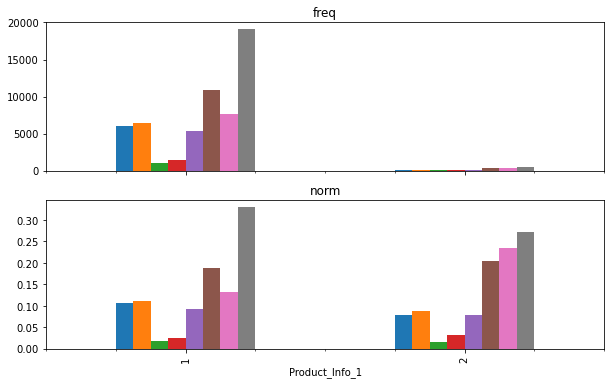

In [7]:
group_col_plot(product_cols[0])

__Product Info 1__ 

First col doesn't look very helpful. Wouldn't be a bad idea to eliminate it.

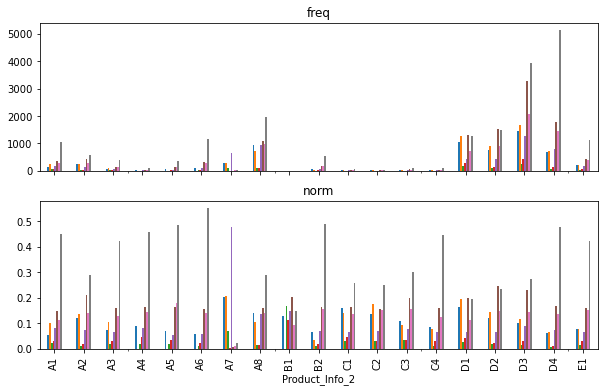

In [8]:
group_col_plot(product_cols[1])

__Product Info 2__

This column appears to have a lot of variability and may be useful in the model. Noticeably the D series has most of the data and even within the D class, there is a lot of variability. Likely will use get_dummies() on this.

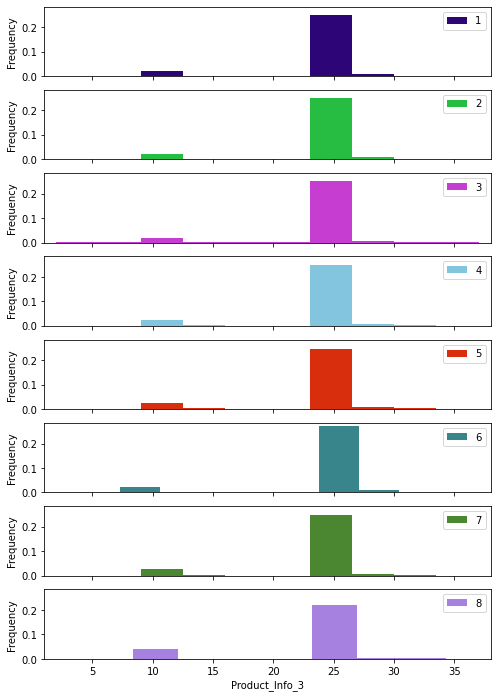

In [9]:
group_hist_plot('Product_Info_3')

__Product Info 3__

Not a lot of variability. Consider elimination.

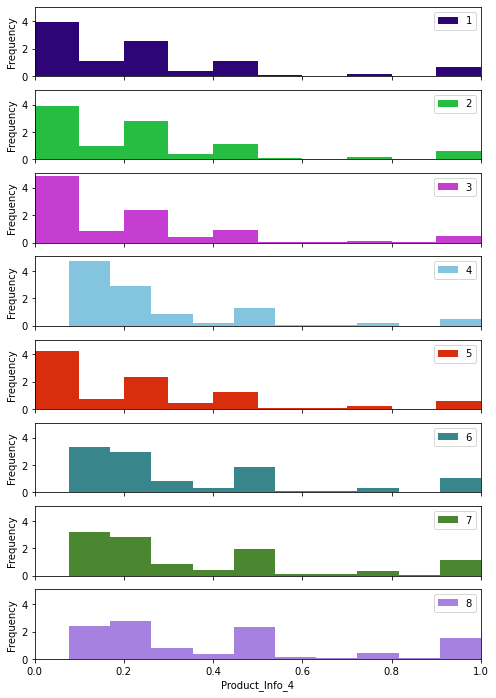

In [10]:
group_hist_plot('Product_Info_4')

__Product Info 4__

Most of these follow the same distribution with the exception of being around the 0.5 and 0.9 region. 

There is also the trend that classes 6 and 7 have greater frequencies near the 0.2 range.

It's possible that this individual feature could have some use in our analysis.

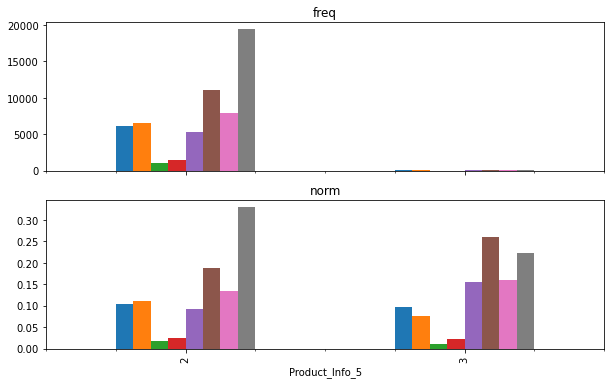

In [11]:
group_col_plot(product_cols[4])

__Product Info 5__

Class 2 dramatically outweighs class 3 in terms of frequency. However the lack of variability between the two subclasses makes it difficult to justify this feature alone.

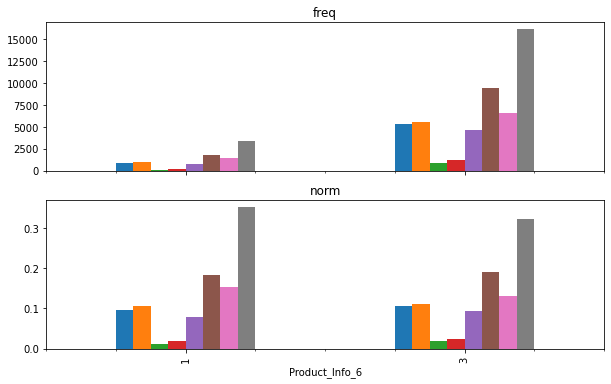

In [12]:
group_col_plot(product_cols[5])

__Product Info 6__

Class 3 appears at a much greater frequency than class 1, but it looks like the distributions within the classes are identical.

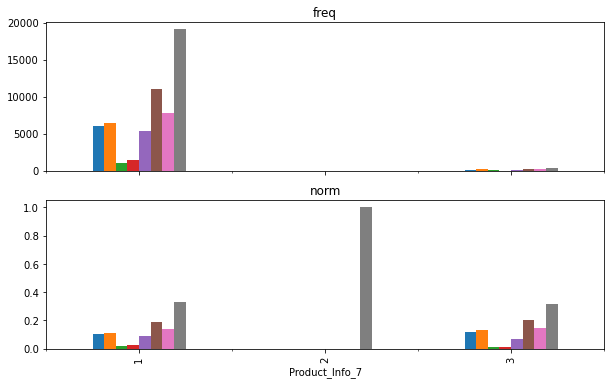

In [13]:
group_col_plot(product_cols[6])

__Product Info 7__

Something interesting within this is that everyone who selected '2' for Product_Info_7 got one class. It may be worth engineering a feature from this alone since the distributions within the values of 1 and 3 appear identical.

## Product Conclusions 

- Product 1 - Can eliminate
- Product 2 - Consider engineering features from this column or using get_dummies on the whole thing
- Product 3 - Can eliminate 
- Product 4 - Most variability between the 0.2-0.4 region. Consider engineering 
- Product 5 - Can eliminate
- Proudct 6 - Can eliminate 
- Product 7 - Consider engineering a feature for value of '2'. '1' outweighs everything else dramatically, might not be useful.

Overall these columns are generally imbalanced (low predictive power) or have identical distributions within each class/histogram. I suspect these columns have to do with user input preferences. It is possible that user opinion matters very little when it comes to plan selection. 

Overall it is possible that these features could be useful when combined with others. Individually, they don't seem very strong.


# User Physical Features 

- Ins_Age - Normalized age for applicant
- Ht - Normalized ht for applicant
- BMI - Normalized BMI for applicant

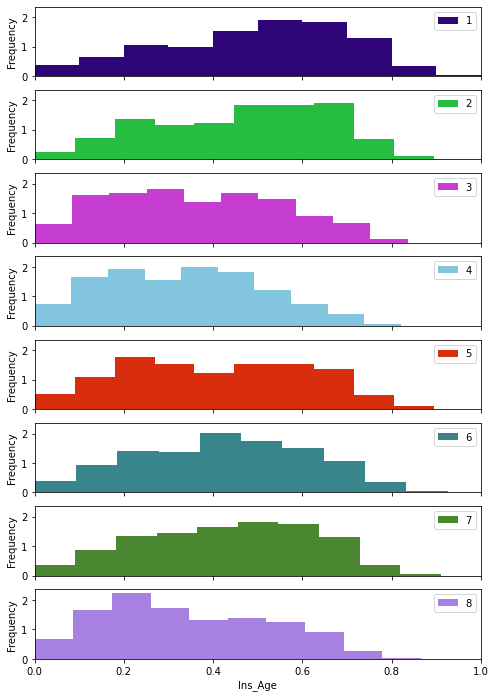

In [14]:
group_hist_plot('Ins_Age')

Text(0.5, 0, 'Ins_Age')

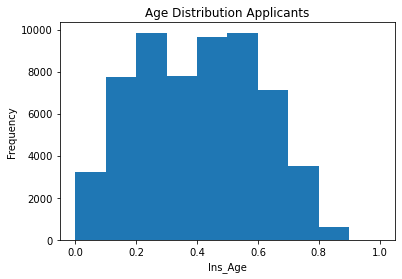

In [15]:
train['Ins_Age'].plot.hist(title='Age Distribution Applicants')
plt.xlabel('Ins_Age')

__Ins Age__

Each plan appears to have a good distribution of ages. There are minor differences among them (e.g. 1, 2 have higher distributions towards the upper end while 4, 8 have more towards the lower end).

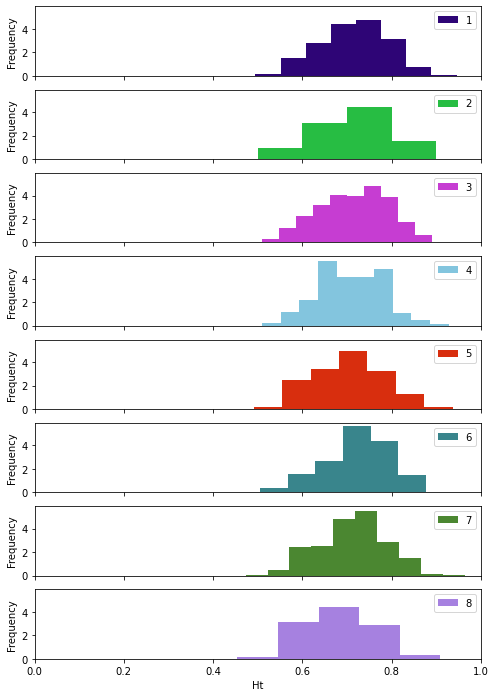

In [16]:
group_hist_plot('Ht')

__Height__

Is height a good predictor? Conventional wisdom says no. The distributions vary slightly, but BMI should be more indicative.

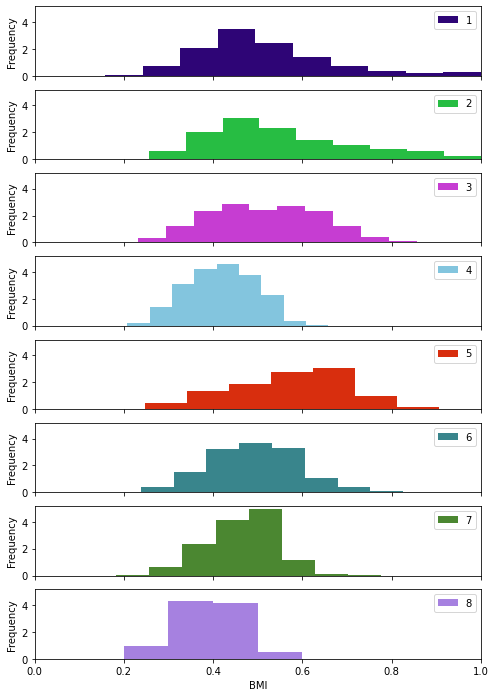

In [17]:
group_hist_plot('BMI')

__BMI__ 

This feature looks much more promising. We can see that there are some classes that completely exclude certain BMIs.

It's possible that this feature and the age feature are related. We should quickly see if there is any indication.

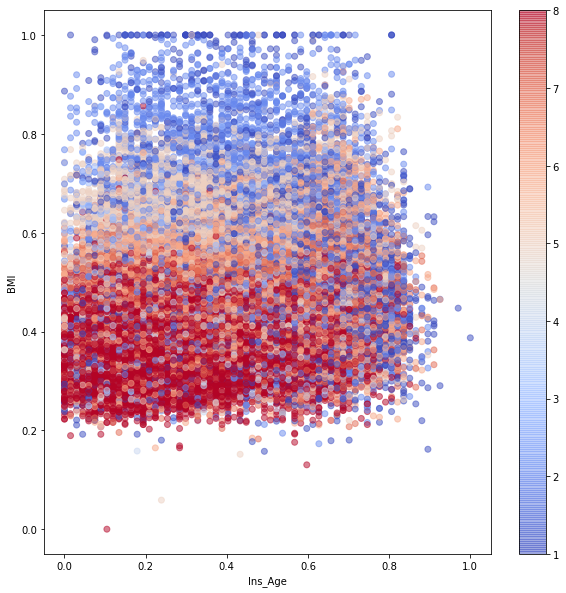

In [18]:
# Scatter plot of Age vs BMI
plt.figure(figsize=(10,10))
scatter = plt.scatter(train['Ins_Age'], train['BMI'], c=train['Response'], cmap='coolwarm', alpha=0.5)
cb = plt.colorbar(scatter)
plt.xlabel('Ins_Age')
plt.ylabel('BMI');

From this it looks like applicants of all ages can have any type of BMI, and any sort of association between the two is difficult to asses.

In [19]:
# Correlation heatmap of physical features
train[['Ins_Age', 'Ht', 'BMI']].corr().style.background_gradient(cmap='coolwarm')

,Ins_Age,Ht,BMI
Ins_Age,1.000000,0.008419,0.137076
Ht,0.008419,1.000000,0.123125
BMI,0.137076,0.123125,1.000000


## Physical Features Conclusion 

- Ins_Age - May be useful. Unclear since all responses have applicants of all ages 
- Ht - Conventional wisdom says this feature is useless. 
- BMI - Promising feature. Include.

## Employment Information 

Employement Info (1-6) - Normalized variables wrt to employment history of applicant

All of these are unlabeled so we won't know what they actually mean. A pairplot could be used to analyze them, but due to the massive imabalance in this dataset it is very difficult to interpret.

In [20]:
# Grab the employment columns
employment_cols = [f'Employment_Info_{i}' for i in range(1,7)] + ['Response']
employment_features = train[employment_cols]
employment_features.drop(columns=['Employment_Info_3', 'Employment_Info_5'], inplace=True)

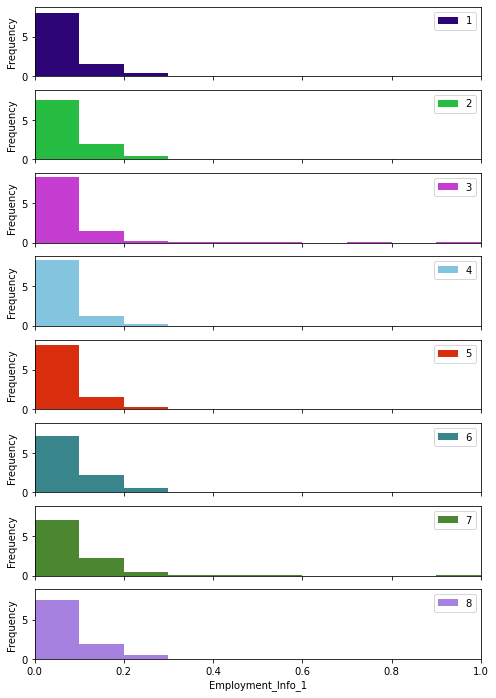

In [21]:
group_hist_plot('Employment_Info_1')

__Employment_Info_1__

Distributions among all classes appear identical, with the exception of Response 3. Unlikely to be useful independently.

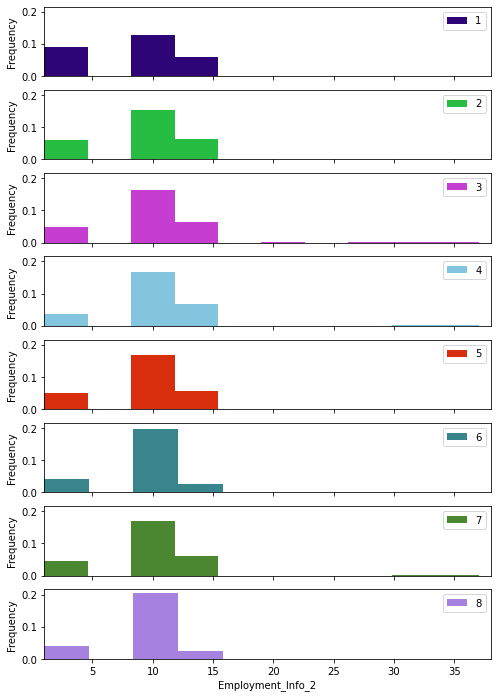

In [22]:
group_hist_plot('Employment_Info_2')

__Employment_Info_2__

Distributions among classes appear to be identical, with the exception of Response 3. There is some variability among ~15 range, but little else.

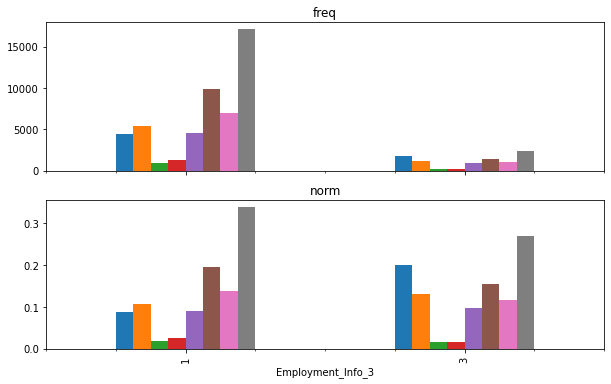

In [23]:
group_col_plot('Employment_Info_3')

__Employment_Info_3__

Distributions among the two appear the same, though class 3 seems to have a greater proportion of the Response 1. Overall distributions appear identical otherwise.

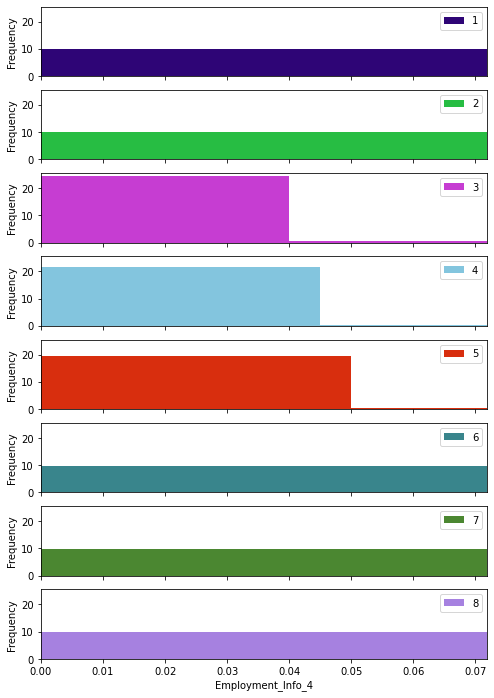

In [24]:
group_hist_plot('Employment_Info_4', poor_norm=True)

__Employment_Info_4__

Incredibly low variability among the distributions. Does not appear useful.

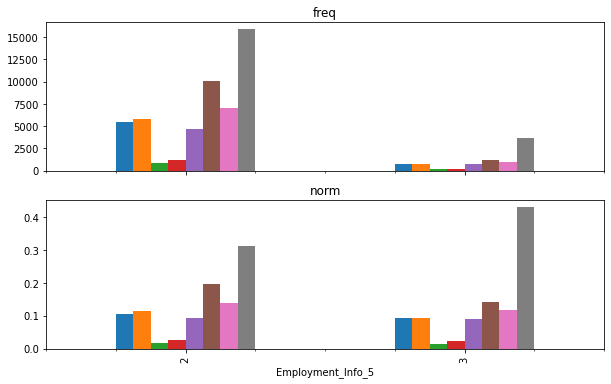

In [25]:
group_col_plot('Employment_Info_5')

__Employment_Info_5__

Again, the variability between the two categories appears to be nearly identical. The exception is that 10% more people with '3' receive Response 8.

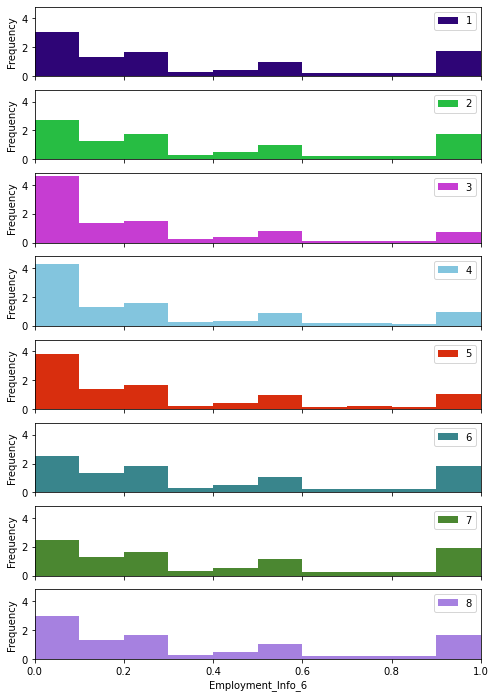

In [26]:
group_hist_plot('Employment_Info_6')

__Employment_Info_6__

The distributions among the classes appear almost identical. This feature alone does not look very helpful.

In [27]:
# Assess these features variability 
employment_features.describe().loc[['count', 'std']]

,Employment_Info_1,Employment_Info_2,Employment_Info_4,Employment_Info_6,Response
count,59362.000000,59381.000000,52602.000000,48527.000000,59381.000000
std,0.082347,4.227082,0.032816,0.349551,2.456833


G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.

G:\Anaconda\lib\site-packages\seaborn\dis

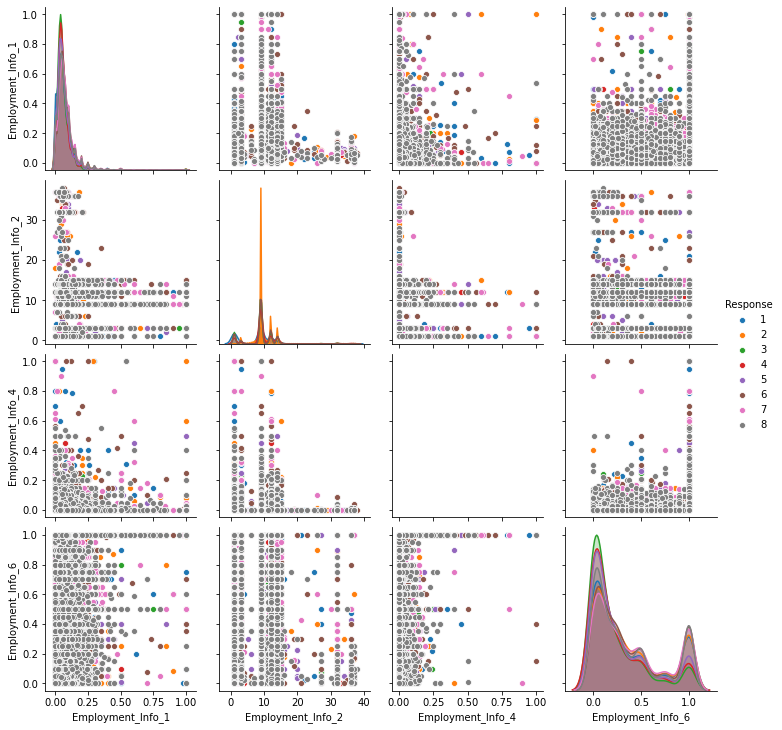

In [28]:
# Do a pairplot to see if there is any sort of relationship that is discernable
# Not visualized here, but removing classes 1 by 1 will show similar distributions throughout the datsaet.
sns.pairplot(employment_features, hue='Response')

These columns are missing some values, but overall it doesn't look like they're going to be very helpful. Most of these have standard deviations less than 0.1. Admittedly, the data is supposedly normalized, but we can see visually that there is very little difference among the classes.

## Employment Information Conclusions 

- Employment_Info_1 - Can eliminate 
- Employment_Info_2 - Very similar distributions. Consider engineering
- Employment_Info_3 - Similar distributions with imbalanced category. Consider engineering, response 1 higher in 3
- Employment_Info_4 - Low variability, can eliminate 
- Employment_Info_5 - Imbalanced with similar distributions. Can eliminate
- Employment_Info_6 - Similar distributions across all classes. Can eliminate.

## Insurance History 

Insured Info (1-7) - Normalized variables wrt to (?) of applicant 


Hard to see how these are "normalized" when they're all categorical, but we'll see.

In [29]:
# Grab insurance columns
insurance_cols = [f'InsuredInfo_{i}' for i in range(1,8)] + ['Response']
insurance_features = train[insurance_cols]

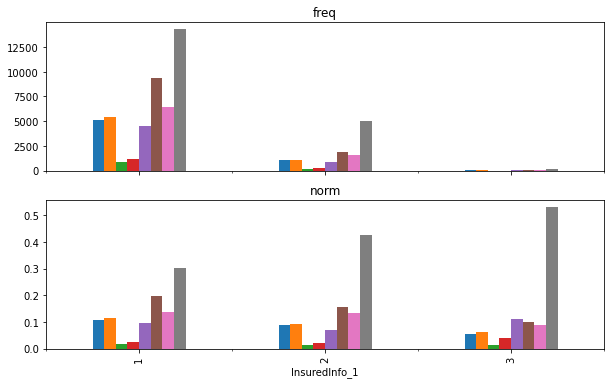

In [30]:
group_col_plot('InsuredInfo_1')

__InsuredInfo_1__

Proportionally more in Response 8 for a higher class. Include this feature by getting dummies.

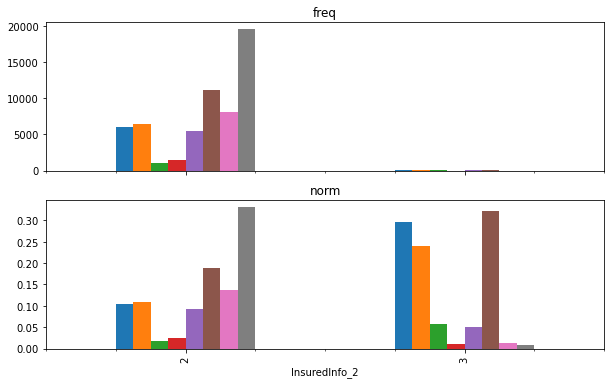

In [31]:
group_col_plot('InsuredInfo_2')

__InsuredInfo_2__

There is much more of category 2 than category 3. However, we can see that having Category 3 basically exempts you from receiving Response 4, 7, or 8. It may be helpful to include this feature. Get dummies.

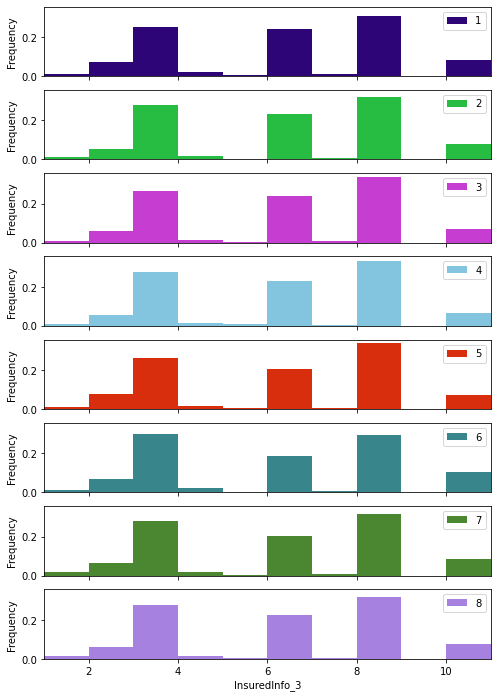

In [32]:
group_hist_plot('InsuredInfo_3')

__InsuredInfo_3__

The distributions among the classes appear identical. Individually, this feature does not appear helpful.

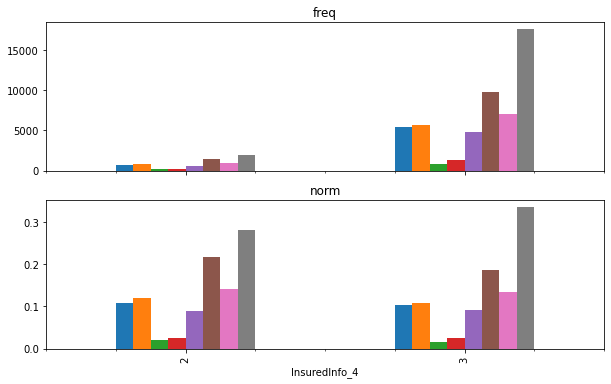

In [33]:
group_col_plot('InsuredInfo_4')

__InsuredInfo_4__

One category vastly outnumbers the other and the distributions are approximately the same. Might be worth excluding this feature.

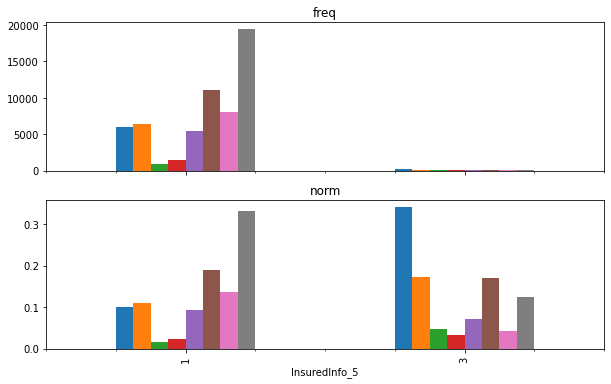

In [34]:
group_col_plot('InsuredInfo_5')

__InsuredInfo_5__

Again, one category vastly outnumbers the other but the minority category has a distinctly different profile. It may be worth including this feature.

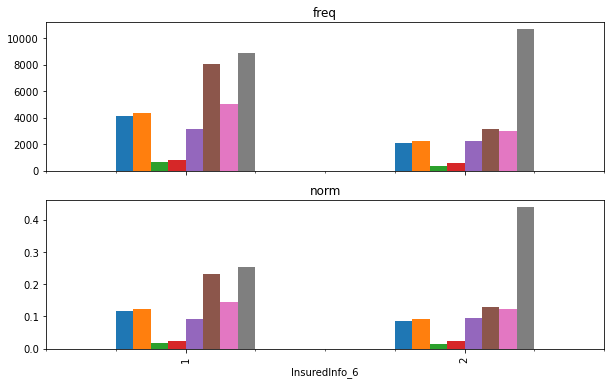

In [35]:
group_col_plot('InsuredInfo_6')

__InsuredInfo_6__

The majority category shows decent distributions across multiple Responses, but the minority category is heavily skewed towards class 8. May be worth including this feature.

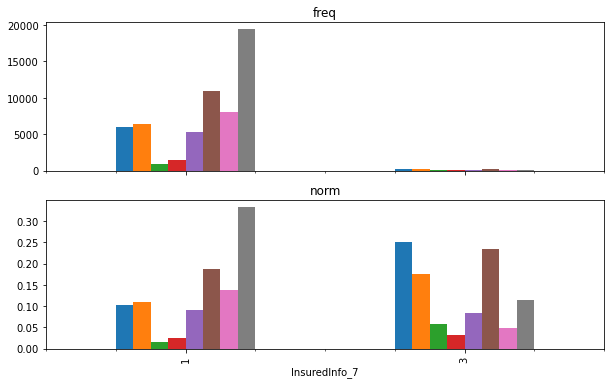

In [36]:
group_col_plot('InsuredInfo_7')

__InsuredInfo_7__

Category 1 >> Category 3, but distributions are incredibly different. May be useful if cases have this identifying feature.

## InsuredInfo Conclusions

Most features have one overrepresented category vs the minority, though it may be helpful if a future test case has a minority feature.

- InsuredInfo_1 - Potentially useful in determining in excluding Response 8.
- InsuredInfo_2 - Potentially useful in excluding Response 7, 8.
- InsuredInfo_3 - Can exclude
- InsuredInfo_4 - Can exclude 
- InsuredInfo_5 - Potentailly useful in confirming Response 1 
- InsuredInfo_6 - Potentially useful in confirming Response 8 
- InsuredInfo_7 - Potentially useful in excluding Response 8

## Insurance History

Insurance History (1-9) - Normalized variables relating to insurance history of applicant 

In [37]:
# Grab insurance history columns
# 6 is missing, somehow
ins_hist_cols = [f'Insurance_History_{i}' for i in range(1,10) if i != 6] + ['Response']
ins_hist_features = train[ins_hist_cols]

In [38]:
ins_hist_features.head()

,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Response
Id,,,,,,,,,
2,1,1,3,1,0.000667,1,1,2,8
5,2,1,3,1,0.000133,1,3,2,4
6,2,1,1,3,NaN,3,2,3,8
7,2,1,1,3,NaN,3,2,3,8
8,2,1,1,3,NaN,3,2,3,8


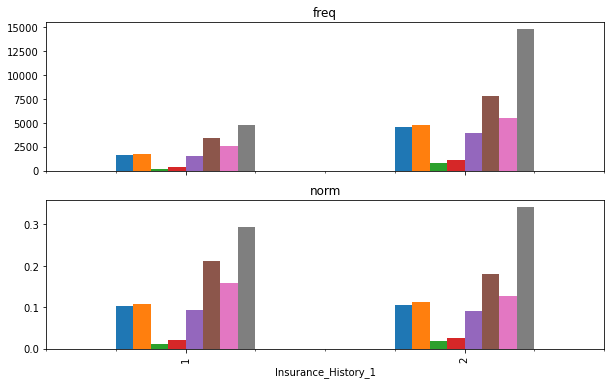

In [39]:
group_col_plot('Insurance_History_1')

__Insurance_History_1__

Similar distributions across both categories. Class 1 has a slightly higher proportion of response 8. Category 2 is the majority. Potentially useful.

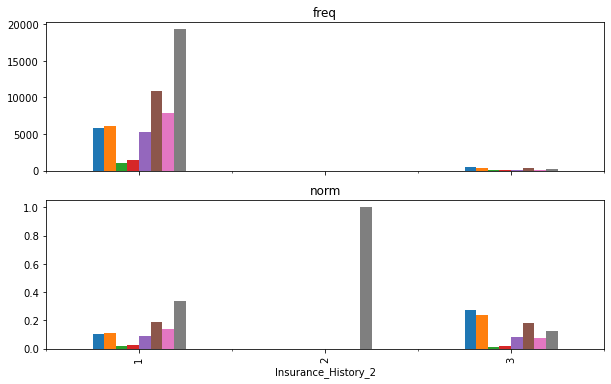

In [40]:
group_col_plot('Insurance_History_2')

__Insurance_History_2__

Category 3 is has a much different distribution than category 1, though category 1 is by far the majority.

Consider grouping into 1 and not 1

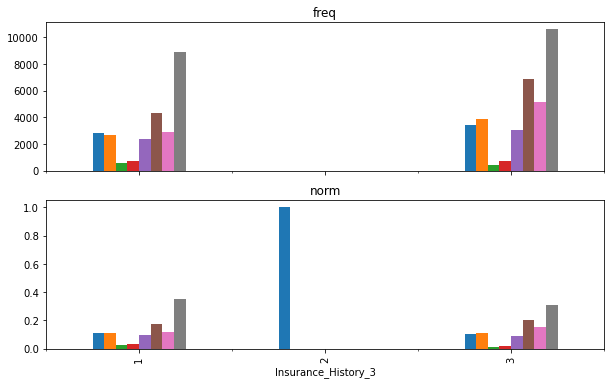

In [41]:
group_col_plot('Insurance_History_3')

__Insurance_History_3__

Very similar distributions across categories 1 and 3. Category 2 is pure but does not have many instances.

Consider grouping into 1 and not 1.

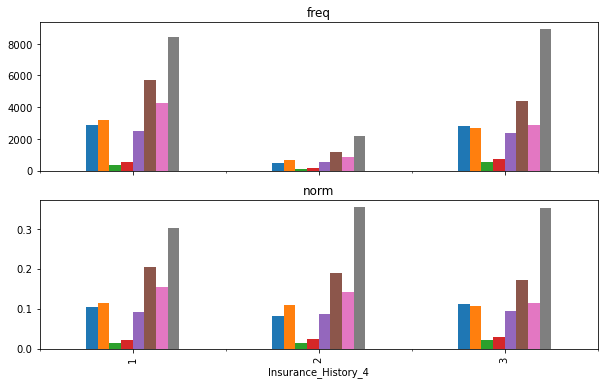

In [42]:
group_col_plot('Insurance_History_4')

__Insurance_History_4__

Very similar distributions across all categories. Likely not valuable.

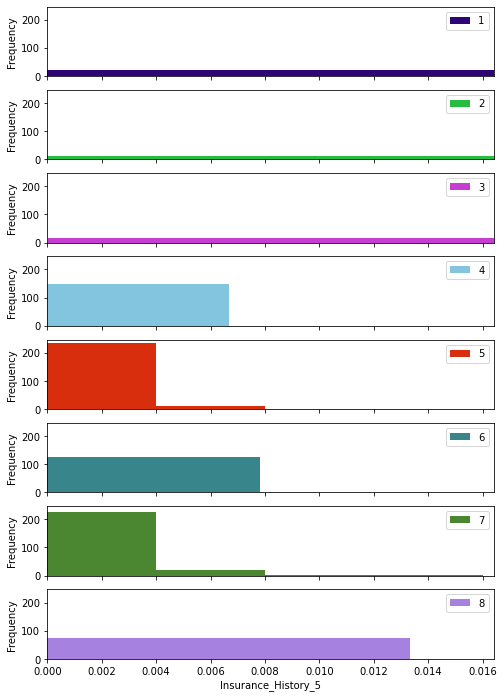

In [43]:
group_hist_plot('Insurance_History_5', poor_norm = True)

__Insurance_History_5__

The amount of range on this column is quite large, and should probably be treated as outliers. Overall, I don't see this column being too useful due to the lack of variance.

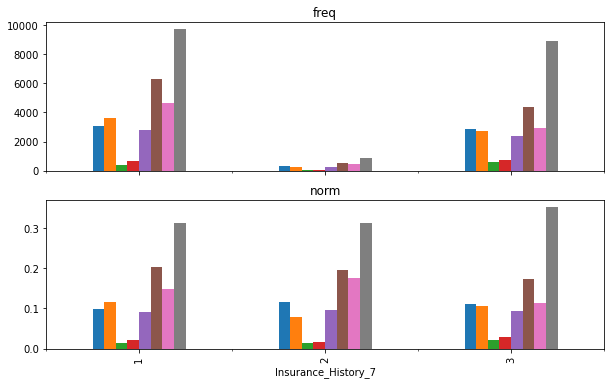

In [44]:
group_col_plot('Insurance_History_7')

__Insurance_History_7__

Not a lot of variance among each category. Can exclude.

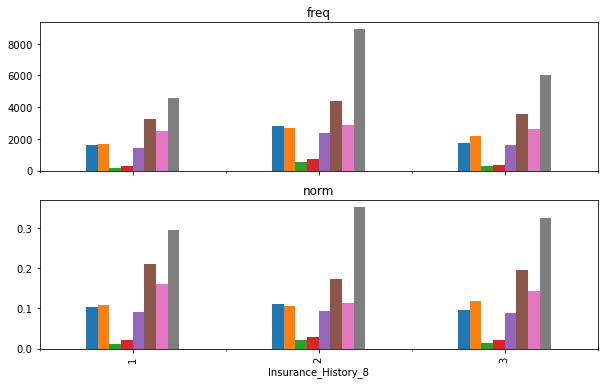

In [45]:
group_col_plot('Insurance_History_8')

__Insurance_History_8__

Again, not a lot of variance among each category.

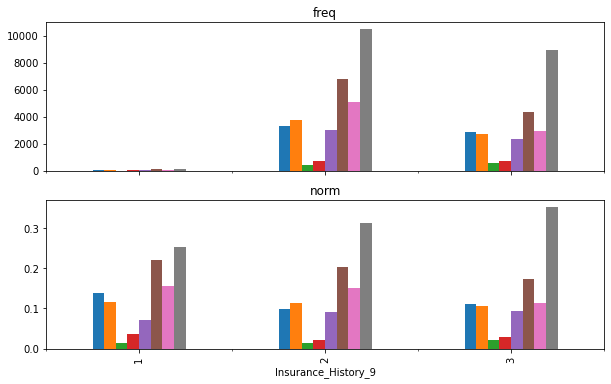

In [46]:
group_col_plot('Insurance_History_9')

__Insurance_History_9__

Overall, this entire category hasn't been very useful in separating the repsonses. The distribution plots resemble the overall response distribution.

## Family History 

Family Hist (1-5) - Normalized Variables wrt family history of applicant.

At a glance, you will see that a majority of this data is absolutely missing.

Family_Hist_1 is the only one with no missing values. The others have data that ranges between 30% to 70% missing. We could eliminate these or try to impute them, but we should first see if it's even worth it by checking if they can distinguish classes.

In [47]:
famhist_cols = [f'Family_Hist_{i}' for i in range(1, 6)] + ['Response']
famhist_features = train[famhist_cols].copy()

In [48]:
famhist_features.head()

,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Response
Id,,,,,,
2,2,NaN,0.598039,NaN,0.526786,8
5,2,0.188406,NaN,0.084507,NaN,4
6,3,0.304348,NaN,0.225352,NaN,8
7,3,0.420290,NaN,0.352113,NaN,8
8,2,0.463768,NaN,0.408451,NaN,8


In [49]:
# How much of this is just missing?
famhist_features.isnull().sum()/famhist_features.shape[0]

Family_Hist_1    0.000000
Family_Hist_2    0.482579
Family_Hist_3    0.576632
Family_Hist_4    0.323066
Family_Hist_5    0.704114
Response         0.000000
dtype: float64

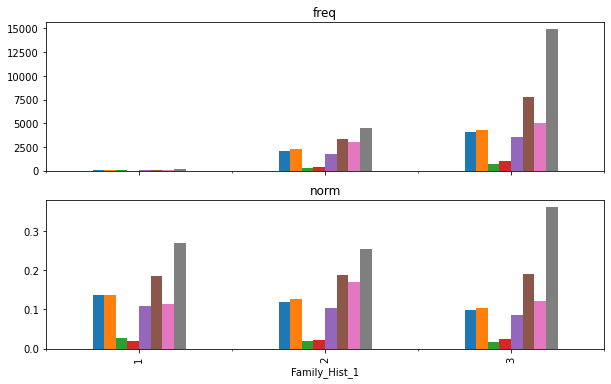

In [50]:
group_col_plot('Family_Hist_1')

__Family_Hist_1__

The data is approximately the same with the exception of Response 7 between category '2' and others. Does not appear useful independently.

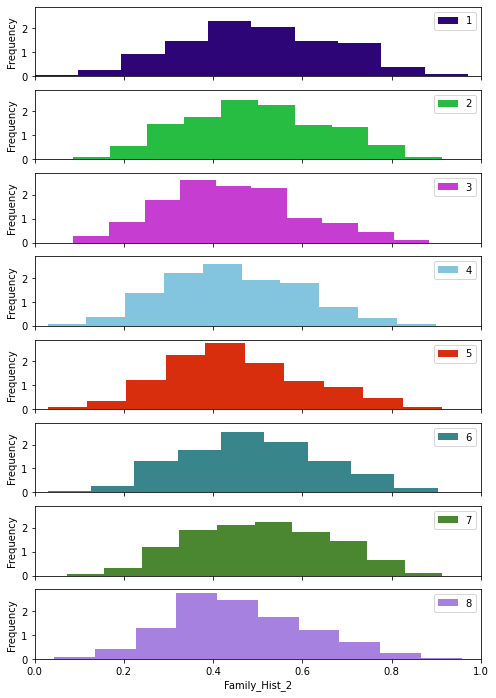

In [51]:
group_hist_plot('Family_Hist_2')

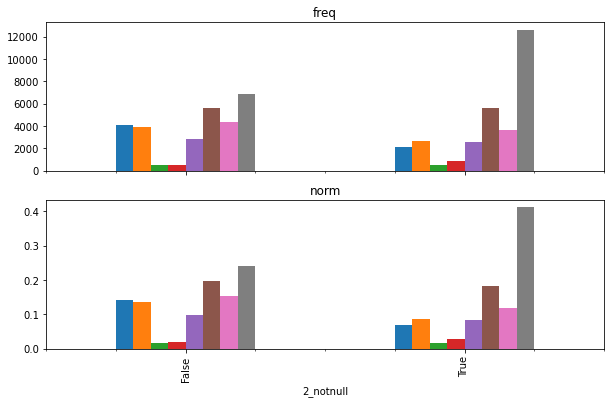

In [52]:
# Create colum based on whether or not it's null
famhist_features['2_notnull'] = famhist_features['Family_Hist_2'].notnull()
group_col_plot('2_notnull', df=famhist_features)

__Family_Hist_2__

Hist  plots look near identical.

Is about 50% Null. Nulls mostly get Response 8. This feature can be engineered in this way.

It would be possible to further subsegment this into quartiles, but for now it looks like checking whether or not it is null will suffice.

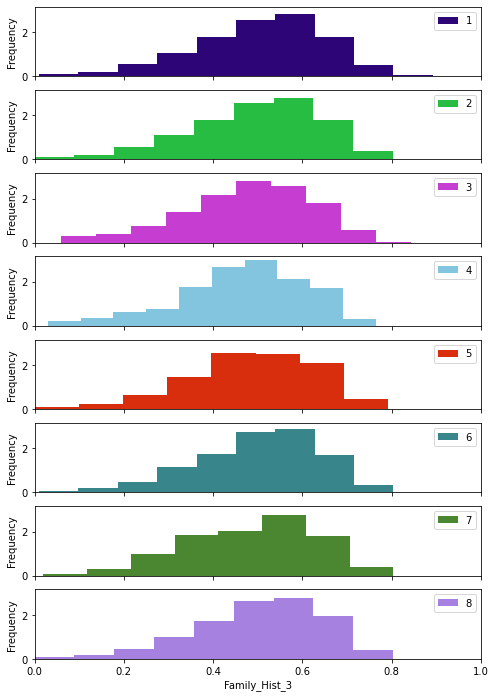

In [53]:
group_hist_plot('Family_Hist_3')

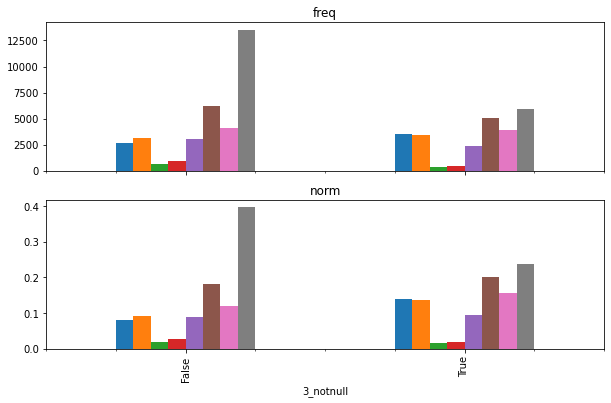

In [54]:
# Create column based on whether or not it's null
famhist_features['3_notnull'] = famhist_features['Family_Hist_3'].notnull()
group_col_plot('3_notnull', df=famhist_features)

__Family_Hist_3__

About 57% nulls.

Similar conclusions as above. Similar distributions across classes yet filling it out dramatically decreases your chances of getting Response 8.

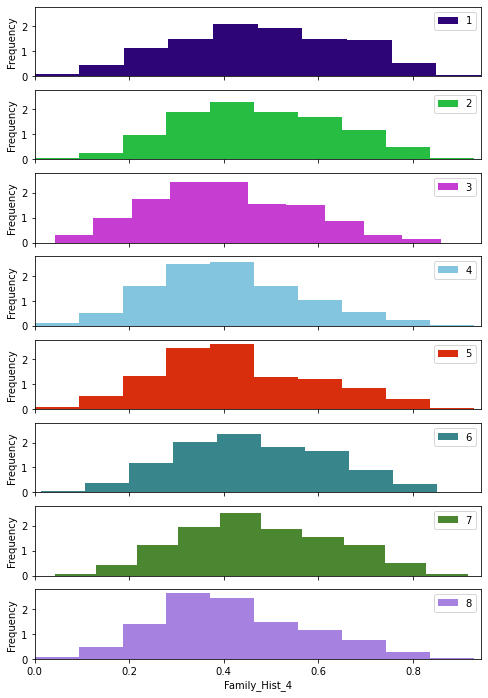

In [55]:
group_hist_plot('Family_Hist_4')

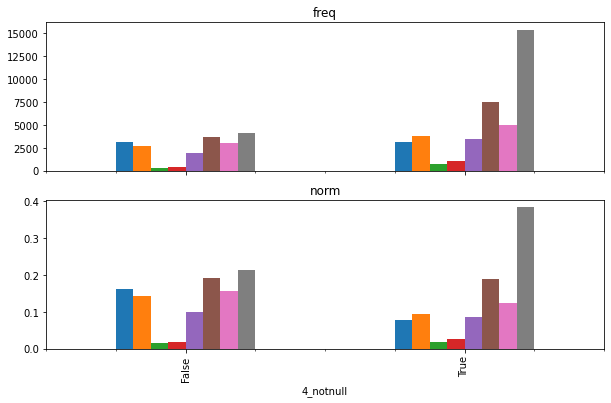

In [56]:
# Create column based on whether or not it's null
famhist_features['4_notnull'] = famhist_features['Family_Hist_4'].notnull()
group_col_plot('4_notnull', df=famhist_features)

__Family_Hist_4__

Same conclusions as previously mentioned...

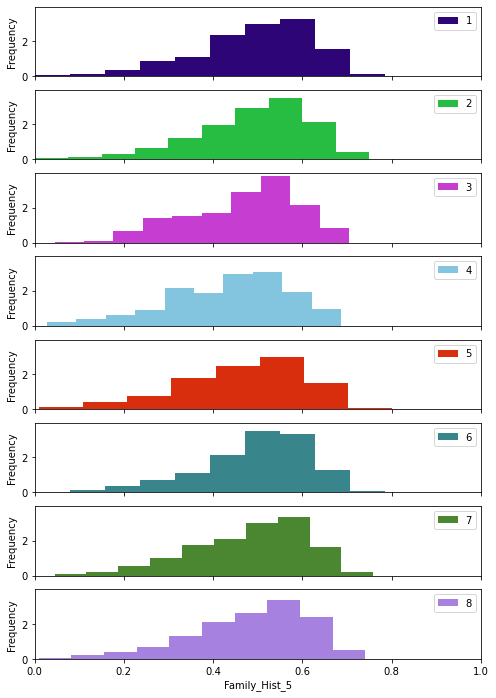

In [57]:
group_hist_plot('Family_Hist_5')

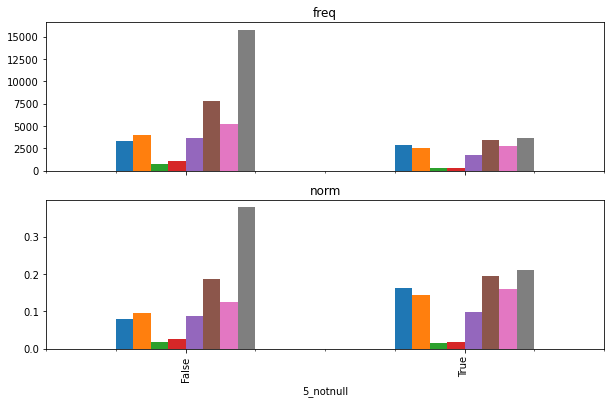

In [58]:
# Create column based on whether or not it's null
famhist_features['5_notnull'] = famhist_features['Family_Hist_5'].notnull()
group_col_plot('5_notnull', df=famhist_features)

__Family_Hist_5__

Same conclusions as before!

## Family_Hist Conclusions 

- Family_Hist_1 - Nearly identical. Consider excluding 
- Family_Hist_2 - Lots of nulls. Derived feature "notnull" may exclude Response 8 
- Family_Hist_3 - Lots of nulls. Derived feature "notnull" may exclude Response 8 
- Family_Hist_4 - Lots of nulls. Derived feature "notnull" may exclude Response 8 
- Family_Hist_5 - Lots of nulls. Derived feature "notnull" may exclude Response 8

Consider engineering features of these notnull features and deriving more features from these derived features.

## Medical History 

Medical History (1-41) - Normalized variables relating to medical history of applicant.

Supposedly normalized

41 columns of Medical History! I imagine that these columns will contain the bulk of our features considering this is an Insurance company.

There are plenty of nulls in this so it may be necessary to impute or generate notnull features from it.

Continuous Features 
- \[1, 2, 10, 15, 24, 32\]

Categorical Features
- Everything else

In [59]:
medhist_cols = [f'Medical_History_{i}' for i in range(1, 42)] + ['Response']
medhist_features = train[medhist_cols]

In [60]:
medhist_features.head()

,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,...,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Response
Id,,,,,,,,,,,,,,,,,,,,,
2,4.0,112,2,1,1,3,2,2,1,NaN,...,1,3,1,2,2,1,3,3,3,8
5,5.0,412,2,1,1,3,2,2,1,NaN,...,3,1,1,2,2,1,3,3,1,4
6,10.0,3,2,2,1,3,2,2,2,NaN,...,3,3,1,3,2,1,3,3,1,8
7,0.0,350,2,2,1,3,2,2,2,NaN,...,3,3,1,2,2,1,3,3,1,8
8,NaN,162,2,2,1,3,2,2,2,NaN,...,3,3,1,3,2,1,3,3,1,8


In [61]:
medhist_cont_cols = [f'Medical_History_{i}' for i in [1,2,10,15,24,32]] + ['Response']
medhist_cat_cols = [col for col in medhist_cols if col not in medhist_cont_cols] + ['Response']

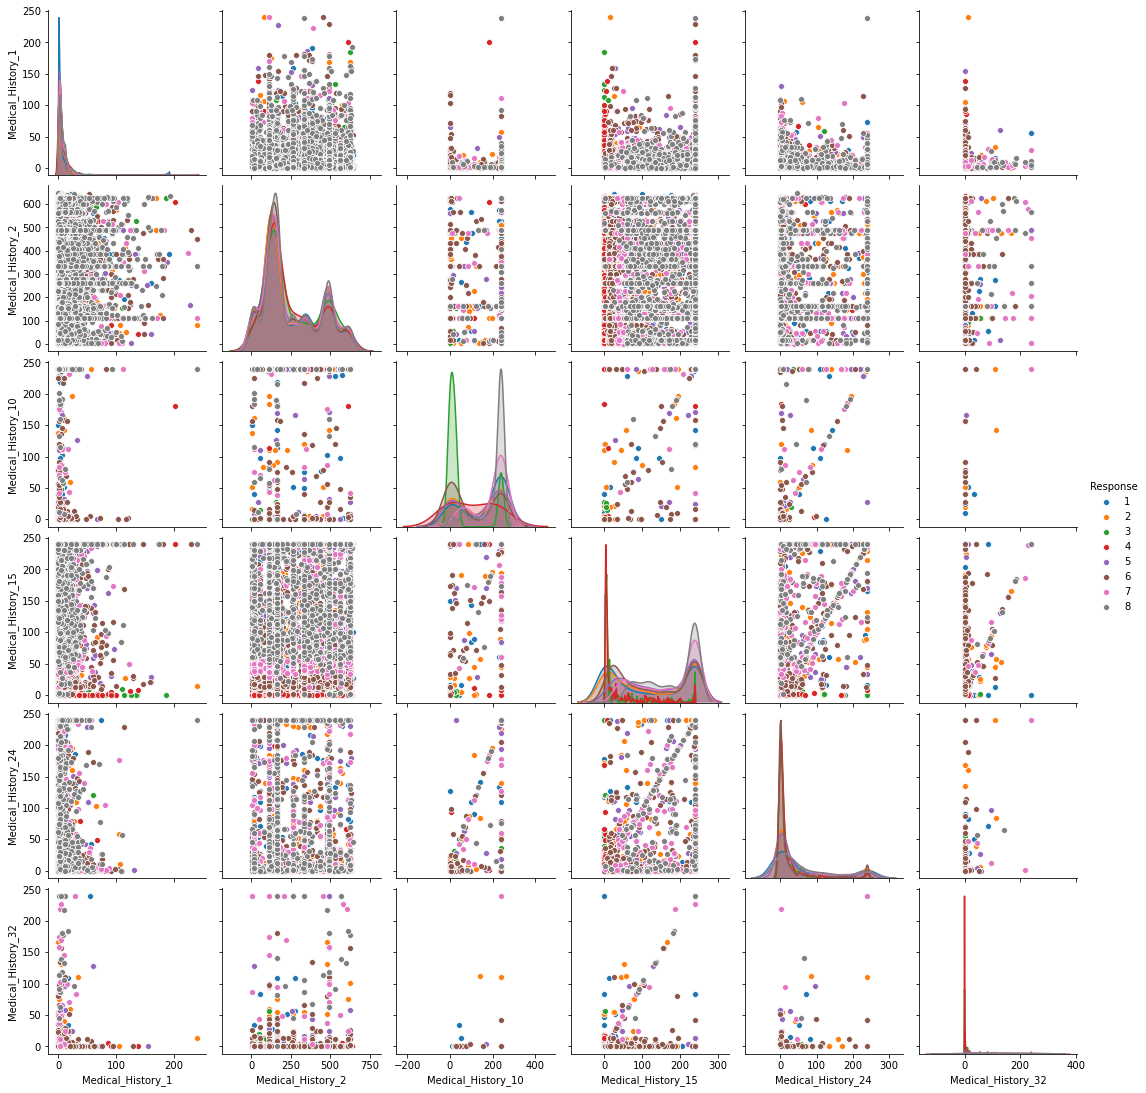

In [62]:
sns.pairplot(medhist_features[medhist_cont_cols], hue='Response')

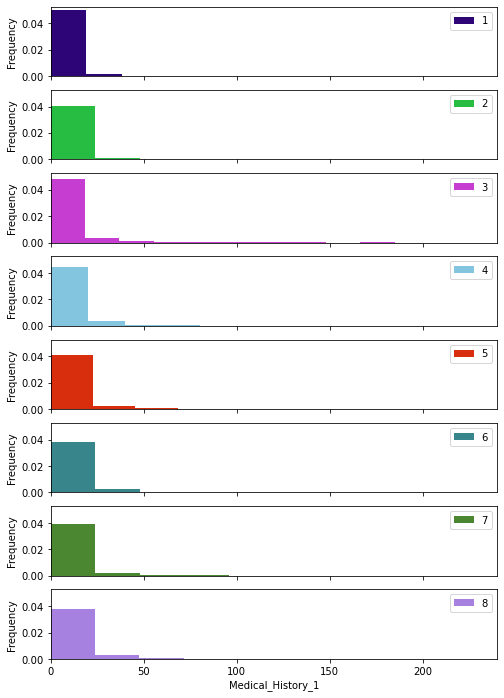

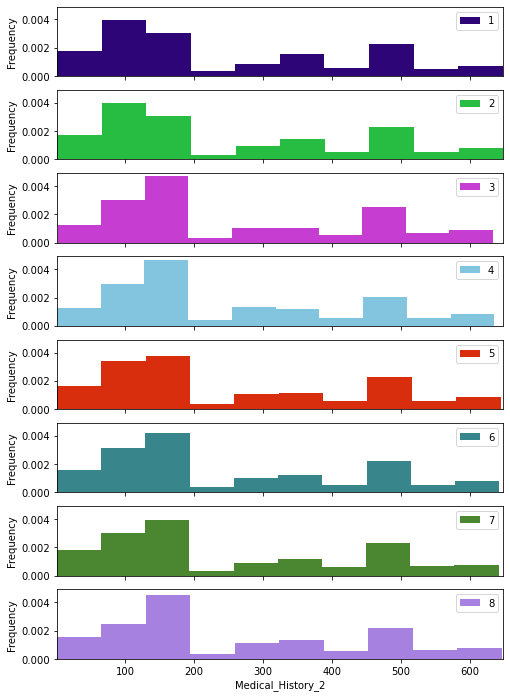

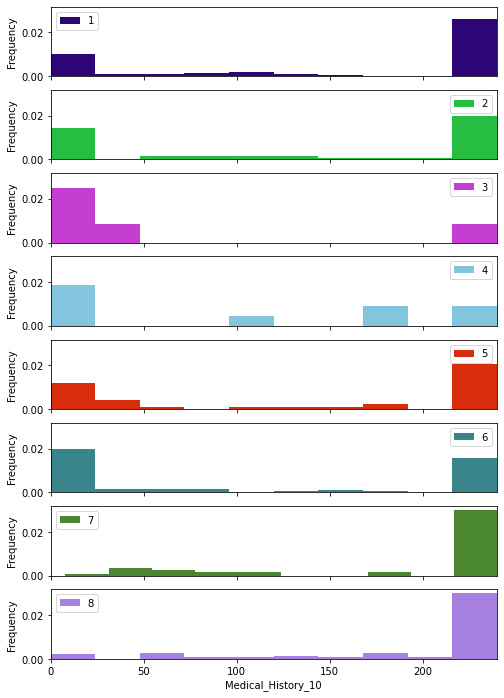

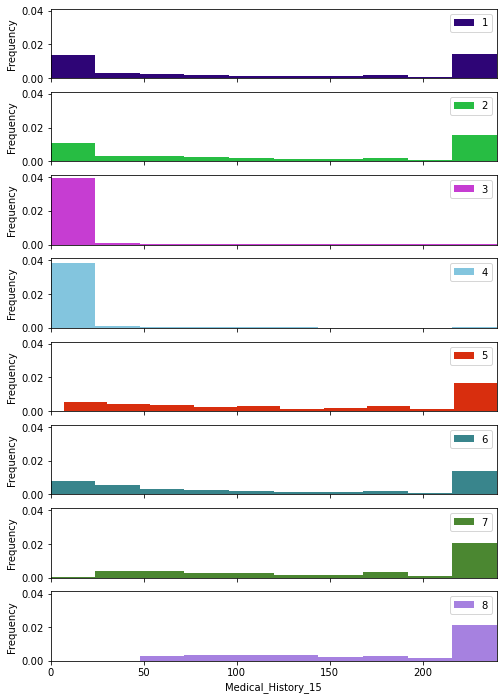

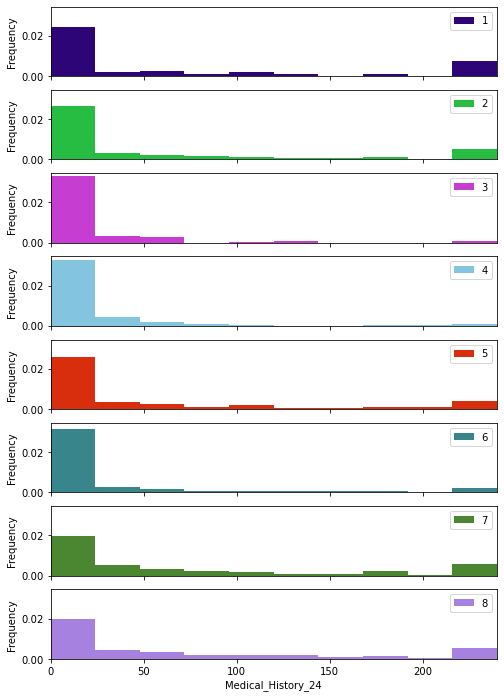

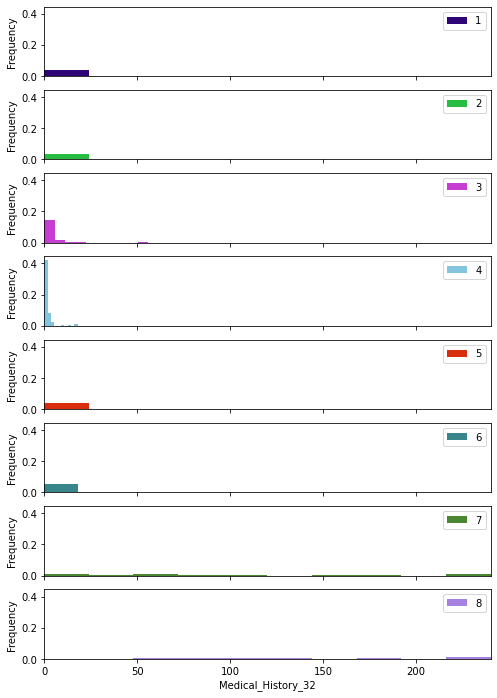

In [63]:
# Get closer visualization of individual features
for col in medhist_cont_cols[:-1]:
    group_hist_plot(col)

In [64]:
medhist_features[medhist_cont_cols].isnull().sum()

Medical_History_1      8889
Medical_History_2         0
Medical_History_10    58824
Medical_History_15    44596
Medical_History_24    55580
Medical_History_32    58274
Response                  0
dtype: int64

__MedHist Continuous Variables__

- Medical_History_1 - Generally low variability. Most values cluster near the lower end. Imputing might not be a good use of time
- Medical_History_2 - Plenty of variability though distributions among classes are very similar.
- Medical_History_10 - 99% null. Drop
- Medical_History_15 - Classes 3/4 look separable. Many nulls. Consider separating along upper/lower quartiles and nulls
- Medical_History_24 - Similar distributions across the board but 93% null. Questionable usefulness
- Medical_History_32 - Poor distributions. Consider separating along upper/lower quartiles and nulls (98%)

## MedHist Categorical Variables

There are no nulls in this, thankfully.

<ipython-input-4-49dc133a3a48>:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



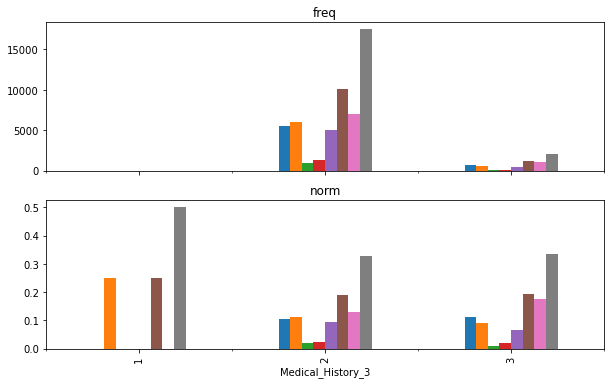

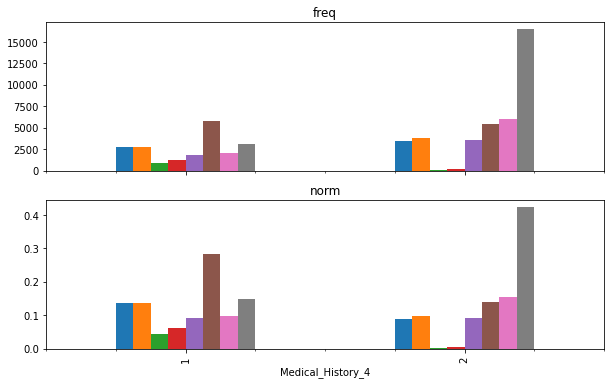

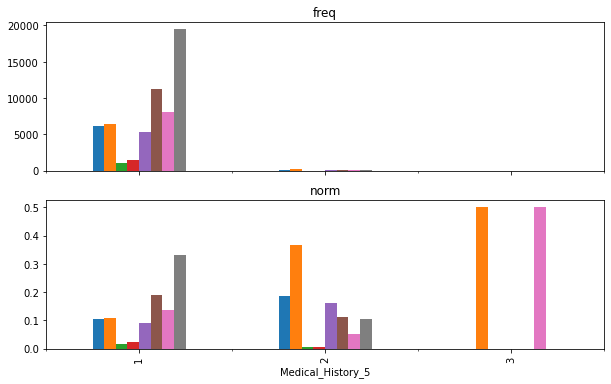

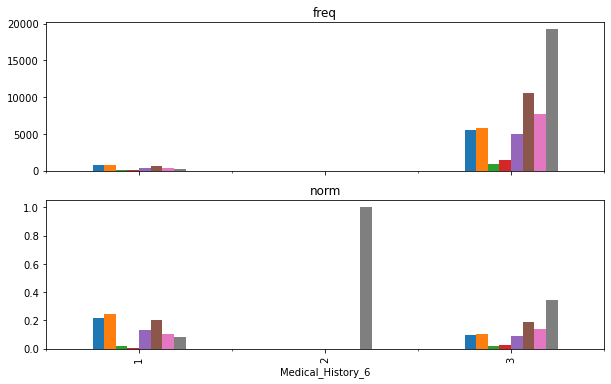

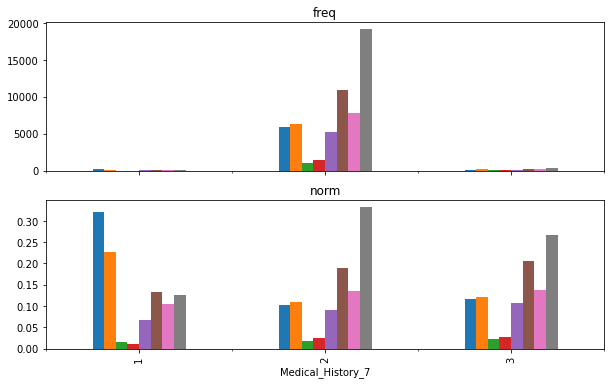

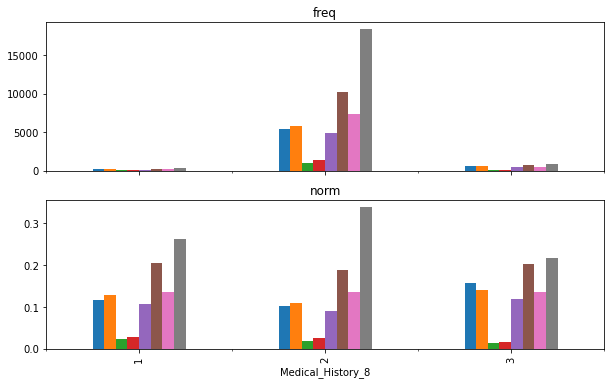

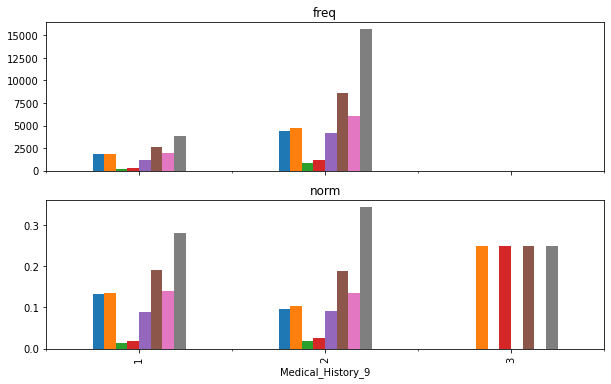

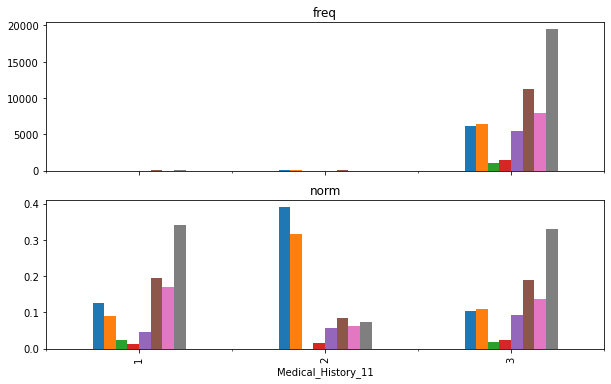

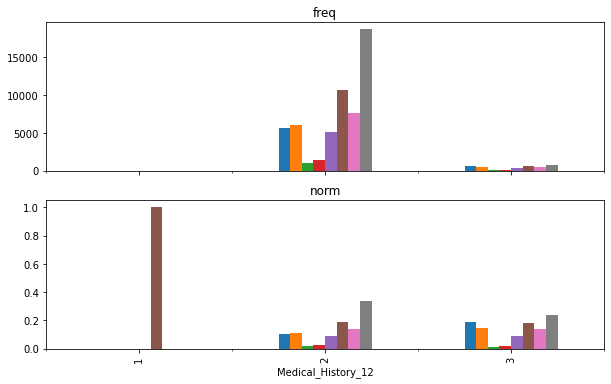

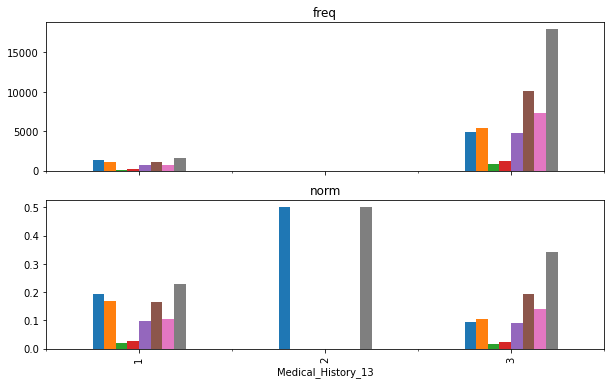

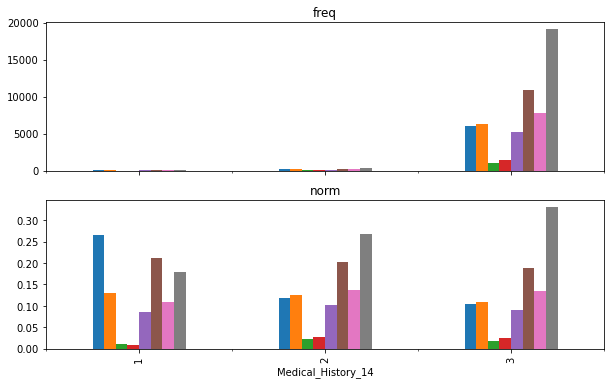

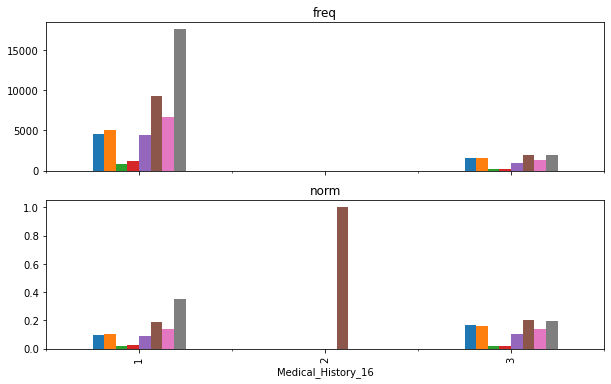

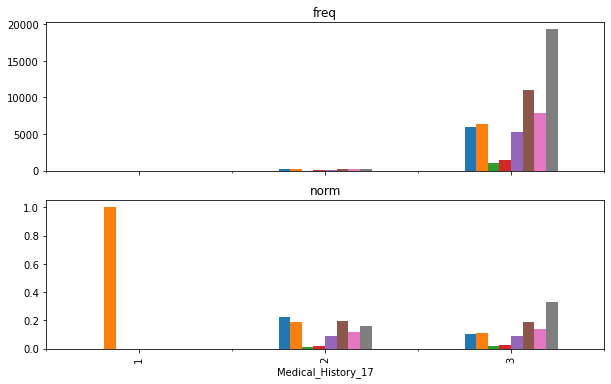

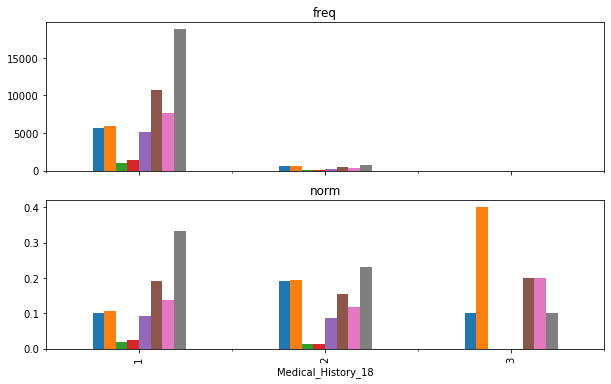

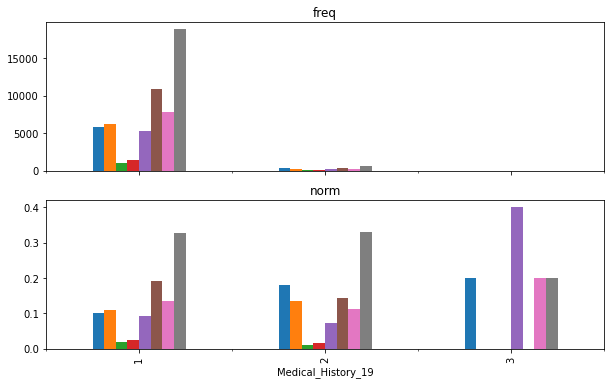

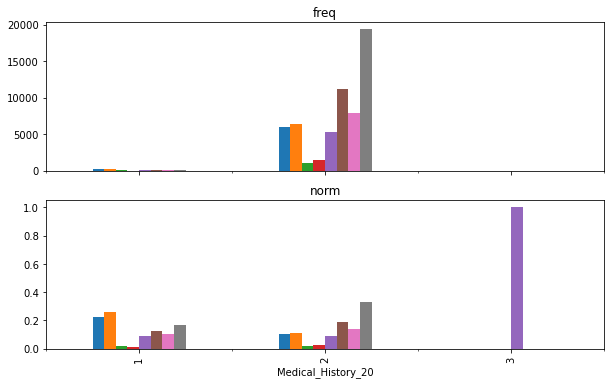

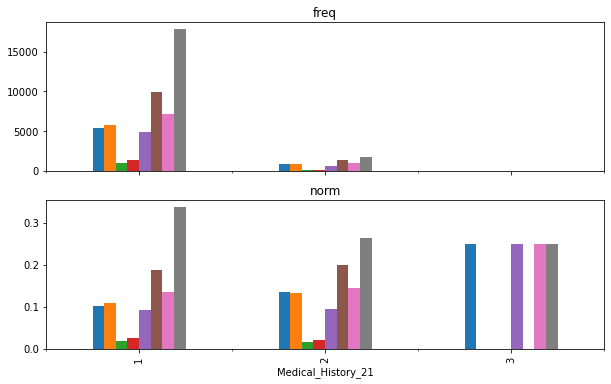

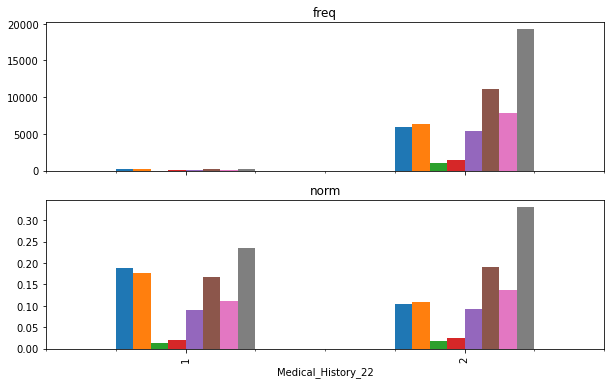

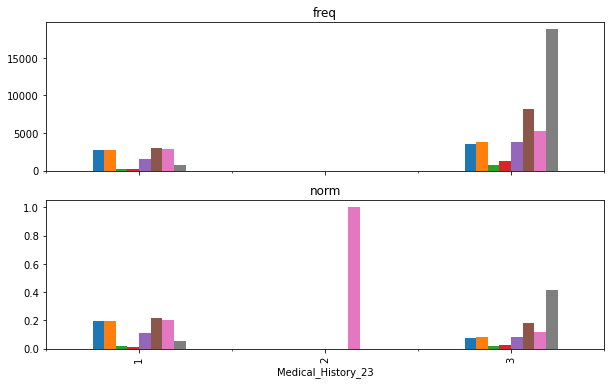

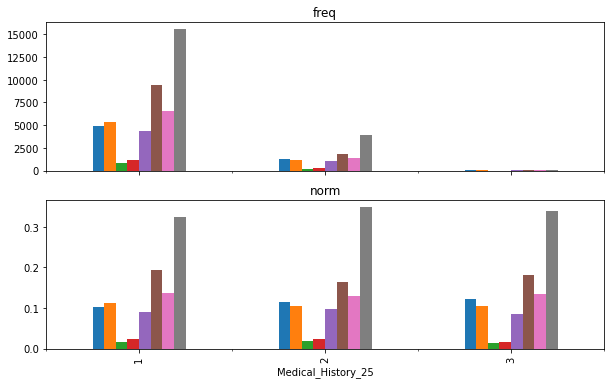

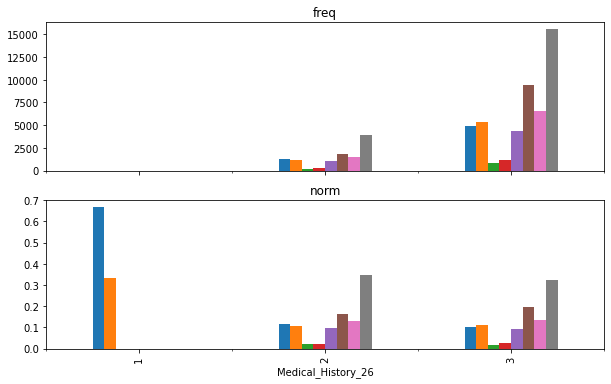

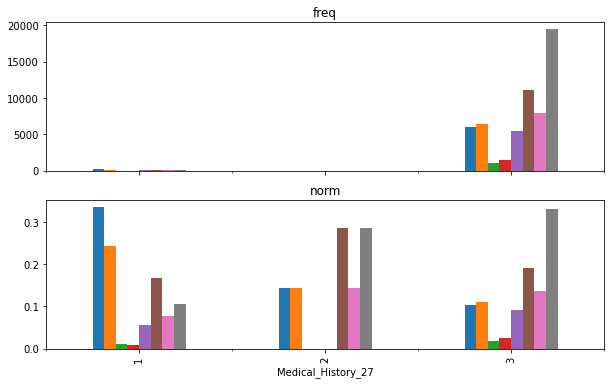

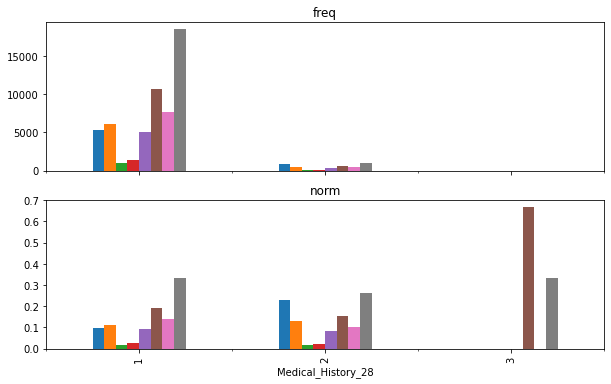

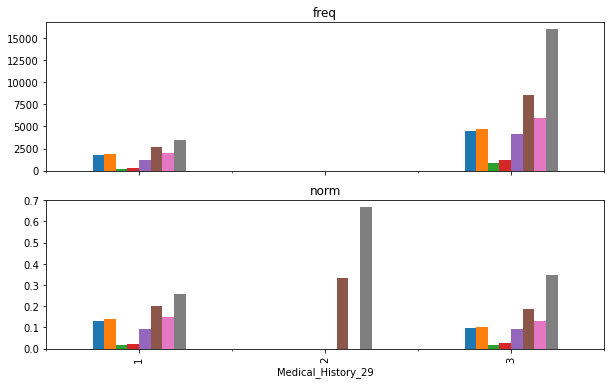

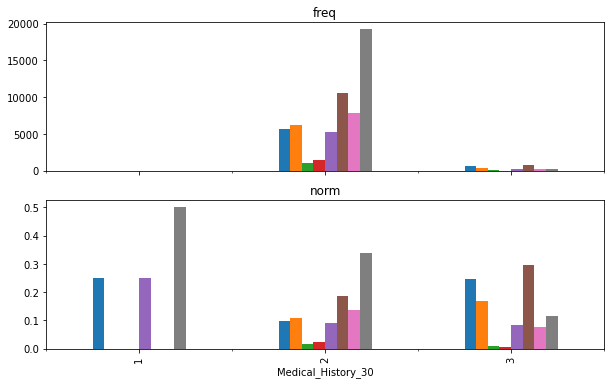

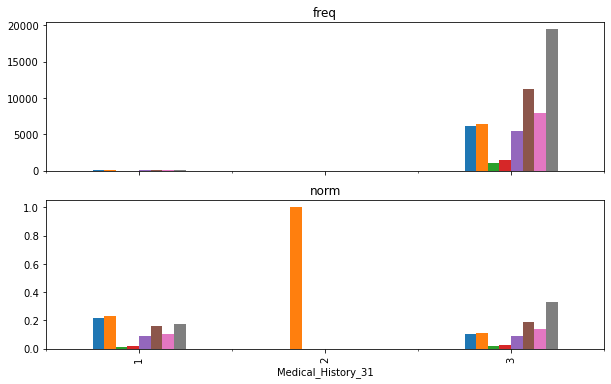

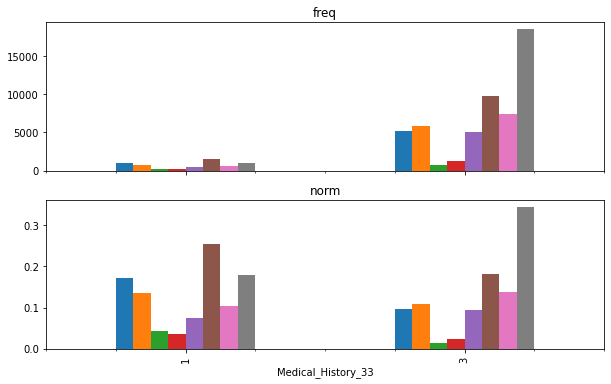

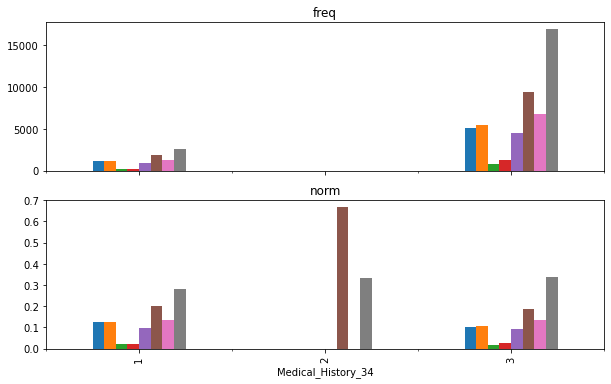

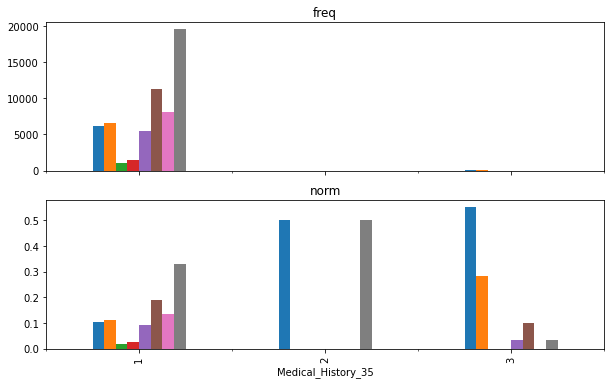

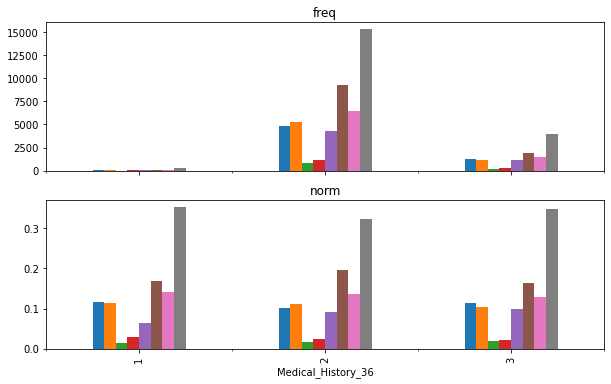

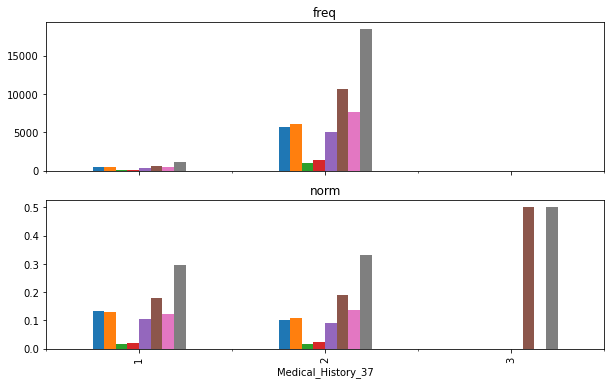

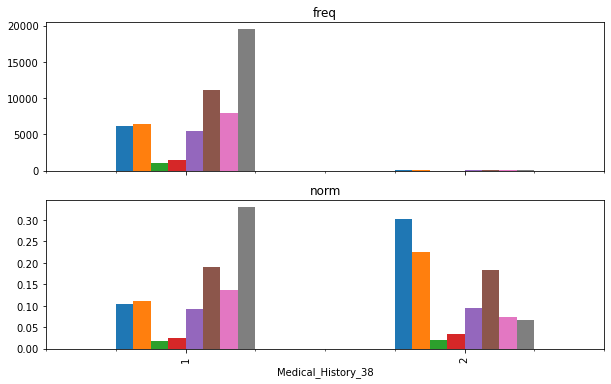

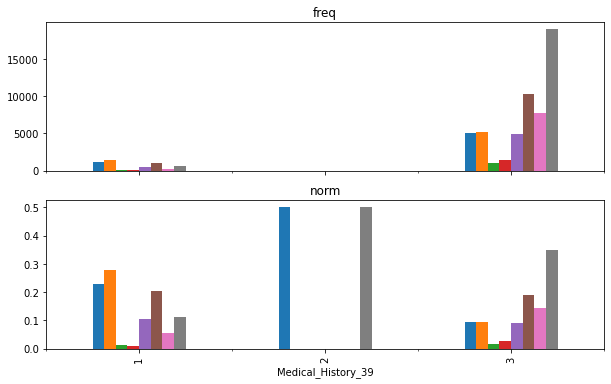

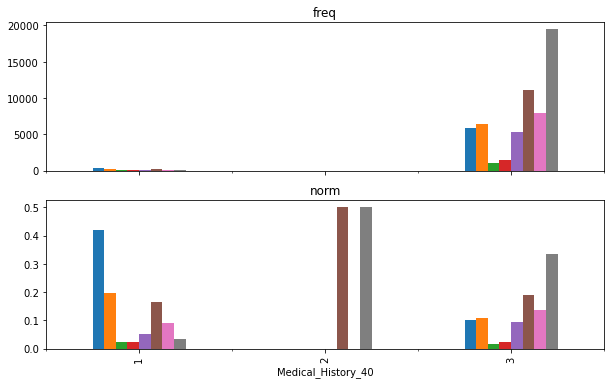

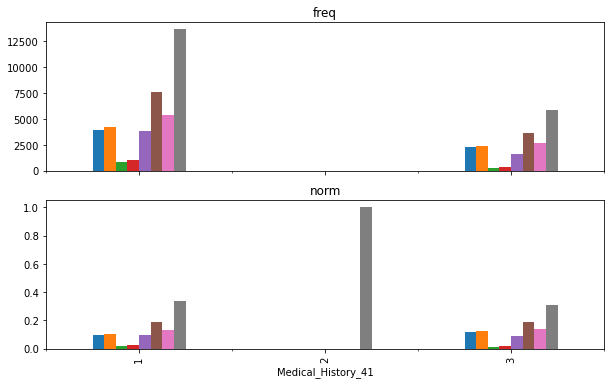

In [65]:
for col in medhist_cat_cols[:-1]:
    group_col_plot(col)

__MedHist Categorical Variables__

There are far too many of these charts to go through, but the trend for most of these is that one category dominates the frequency count, and the minority classes are exceptionally "pure".

There is a choice whether or not to include these as features. On one hand, there is the real possibility that these categories are the reasons why the particular response was chosen. On the other hand, since there is such low data when it comes to that category there is a possibility it would contribute to overfitting. 

As it stands I think these are the following options:
- Ignore features that have the majority category accounting for ~>95% of the feature 
- Group minority categories together vs the majority category
- Include all the data (easiest)

Going forward, we'll have to experiment with all the possibilities.

## Medical Keywords

Medical Keyword (1-48) - Dumy variables relating to presence of a medical keyword in the application.

All of these should be categorical variables.

In [66]:
# Grab medikey columns

medkey_cols = [f'Medical_Keyword_{i}' for i in range(1, 49)] + ['Response']
medkey_features = train[medkey_cols].copy()

<ipython-input-4-49dc133a3a48>:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



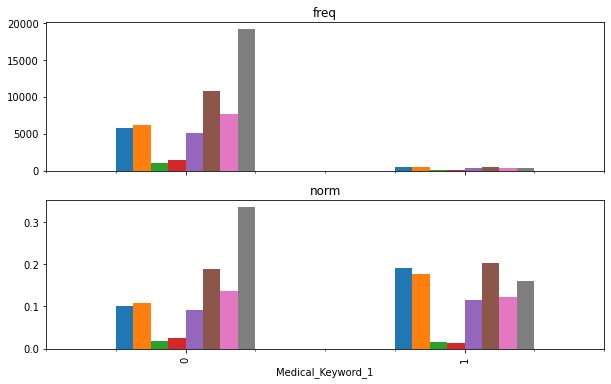

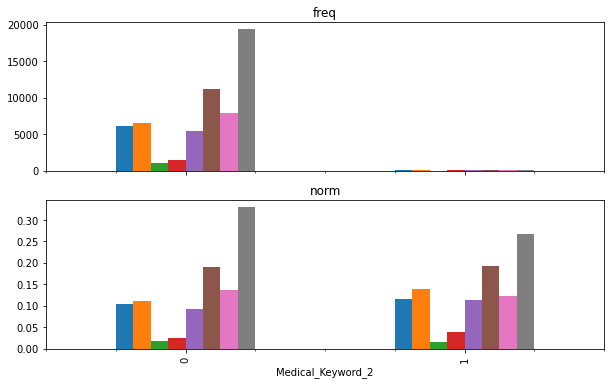

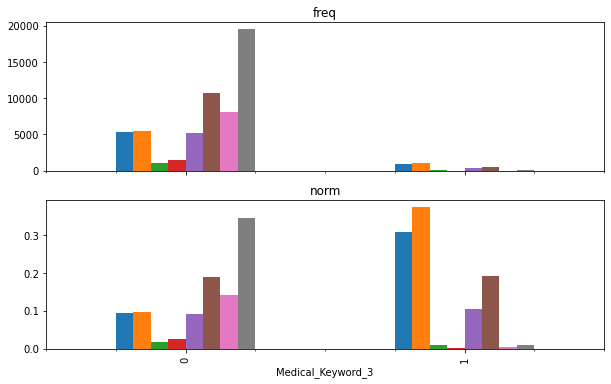

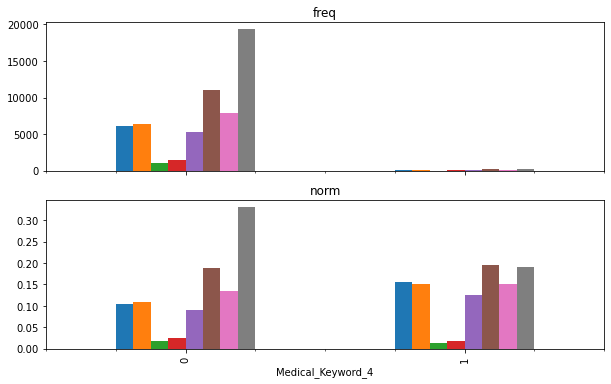

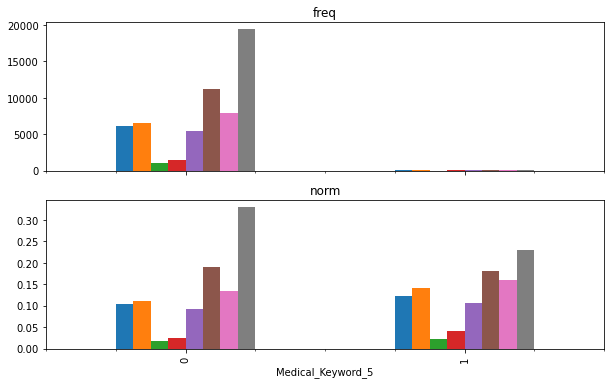

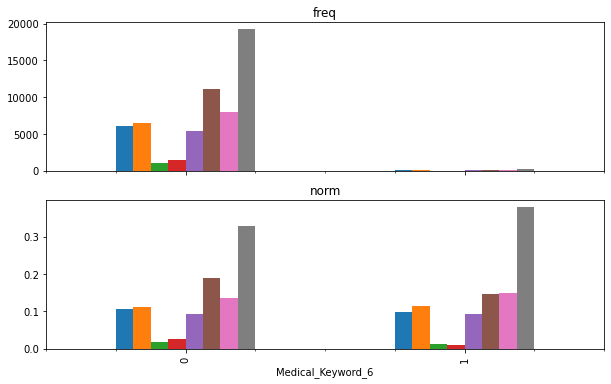

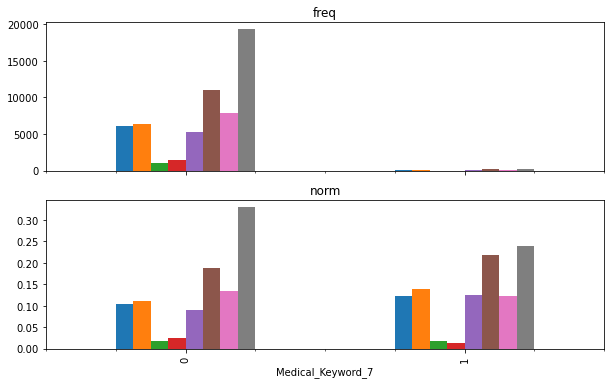

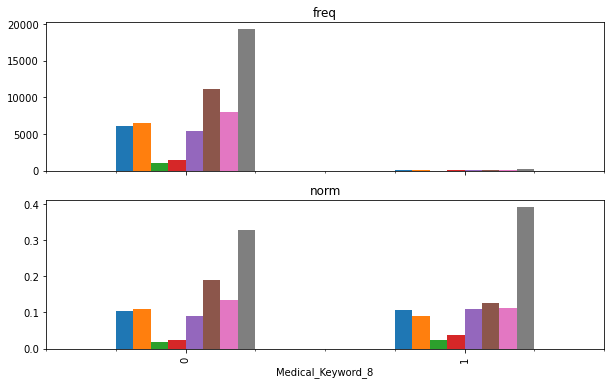

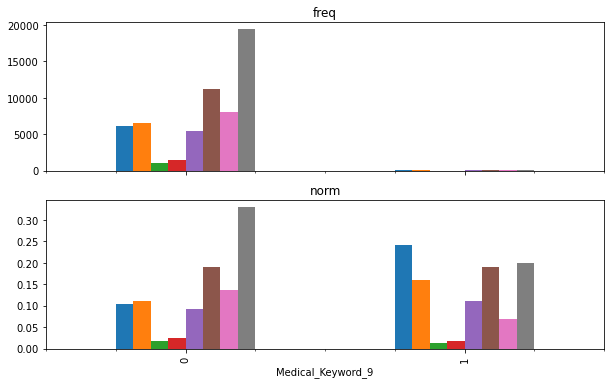

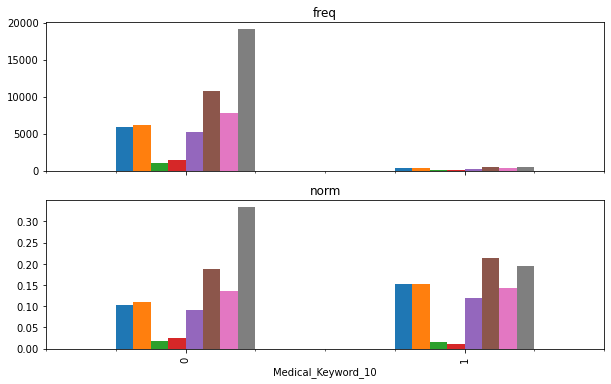

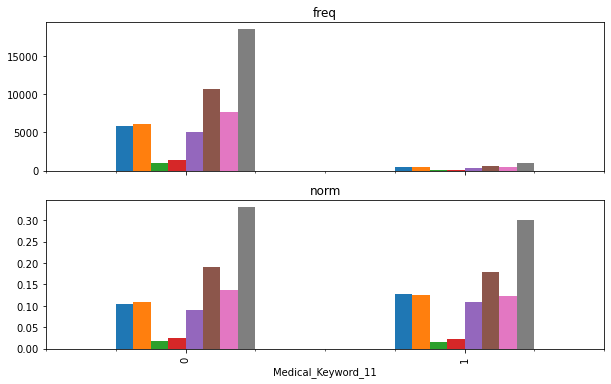

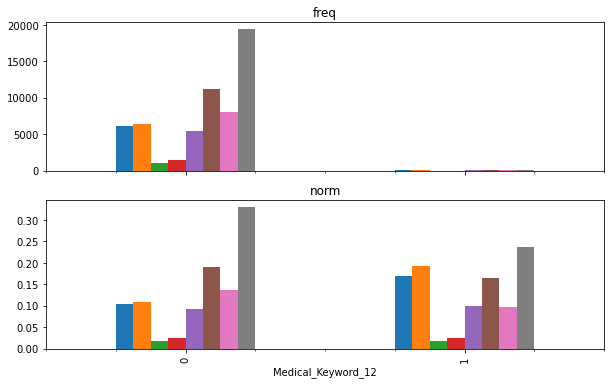

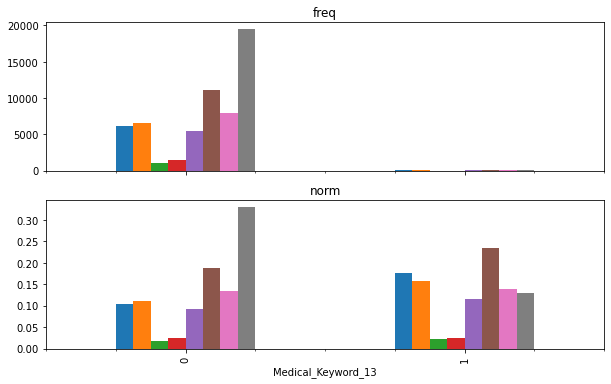

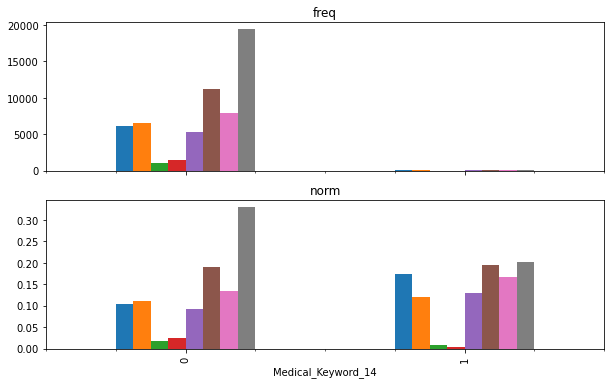

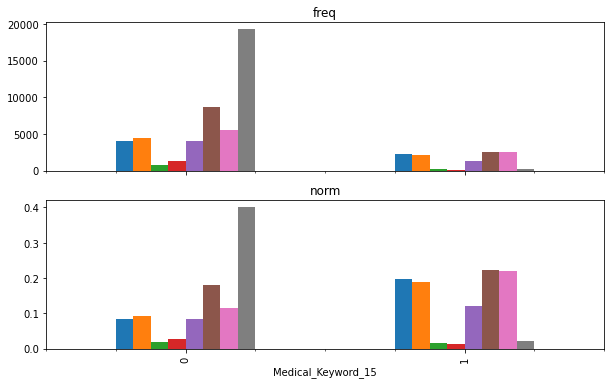

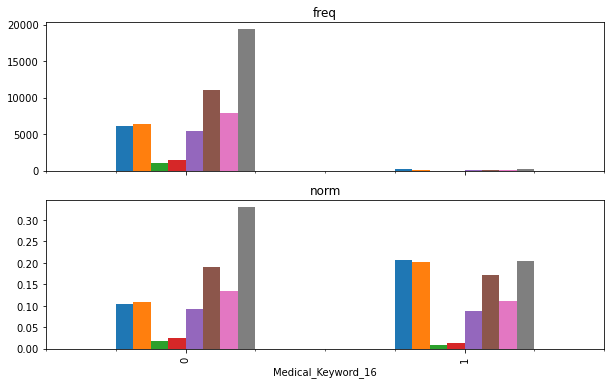

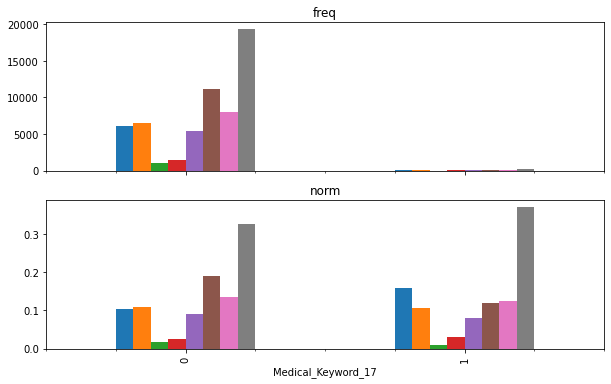

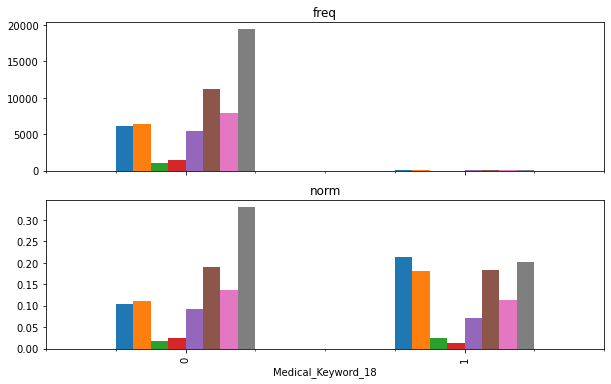

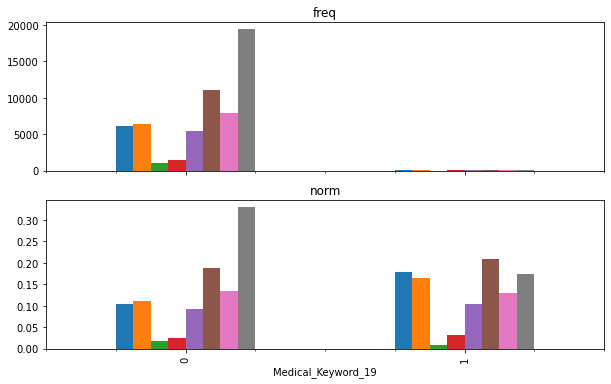

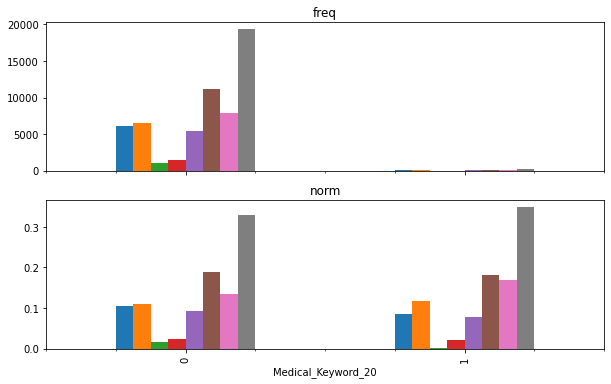

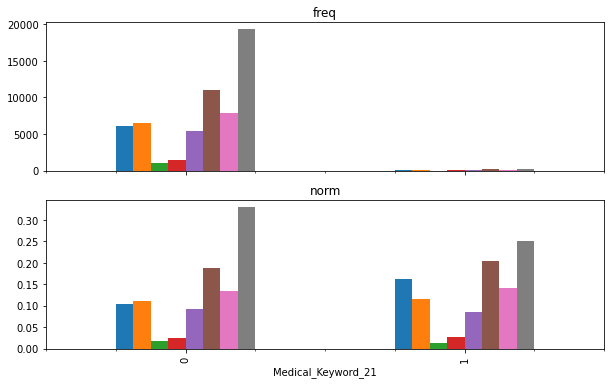

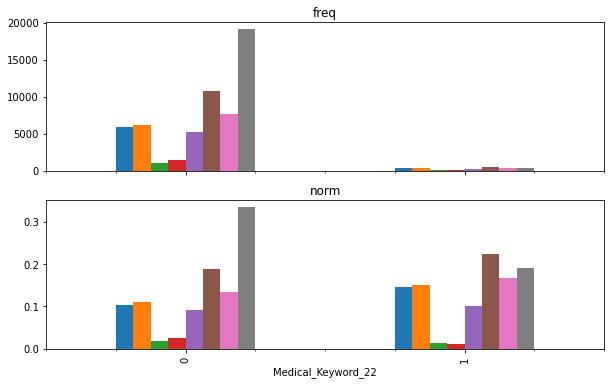

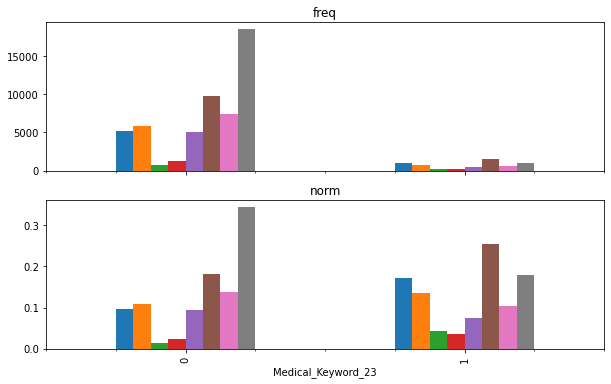

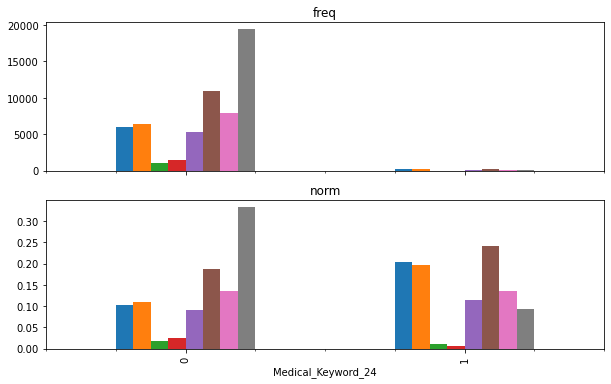

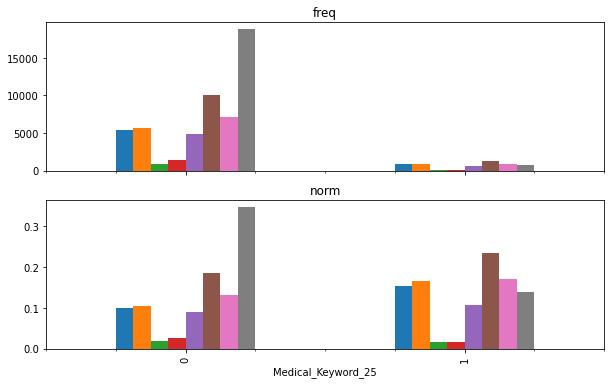

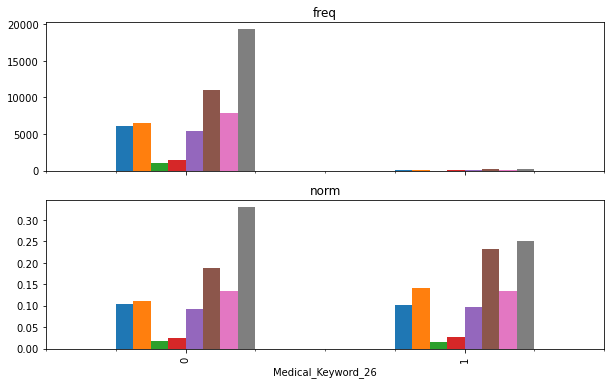

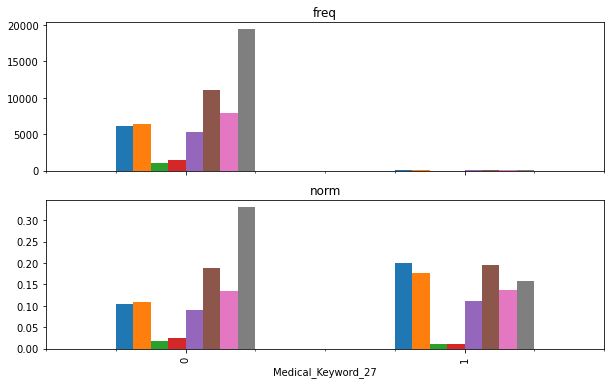

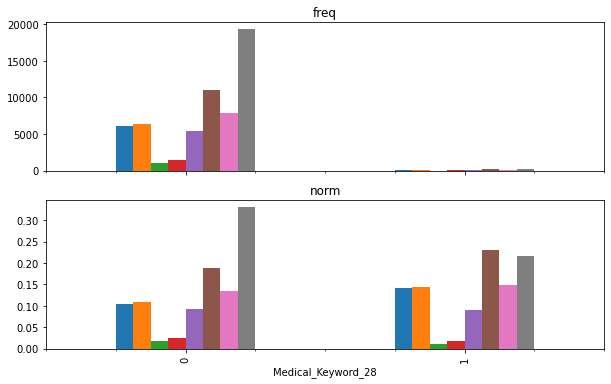

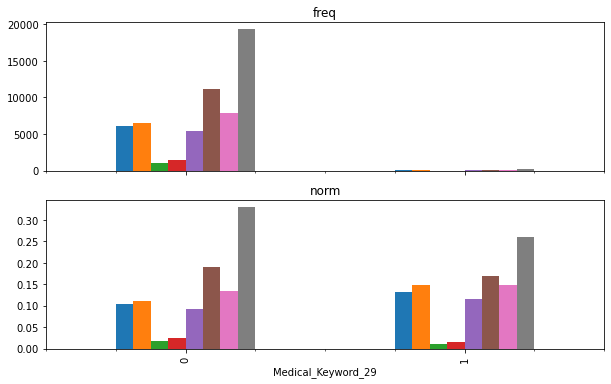

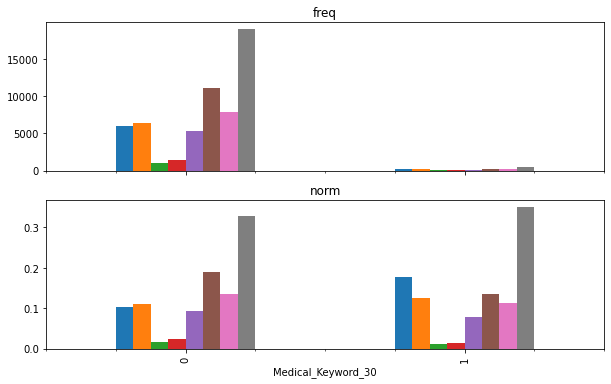

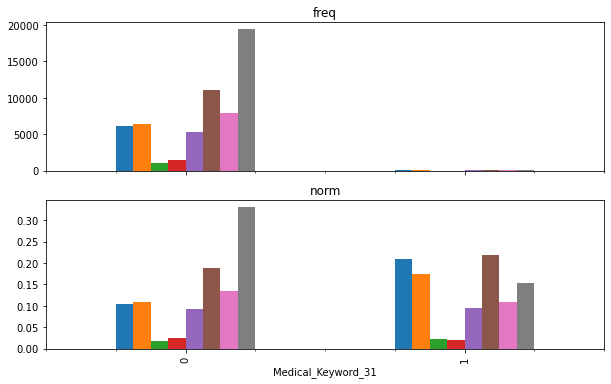

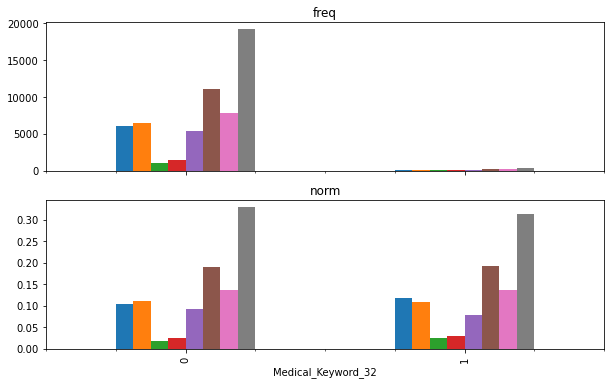

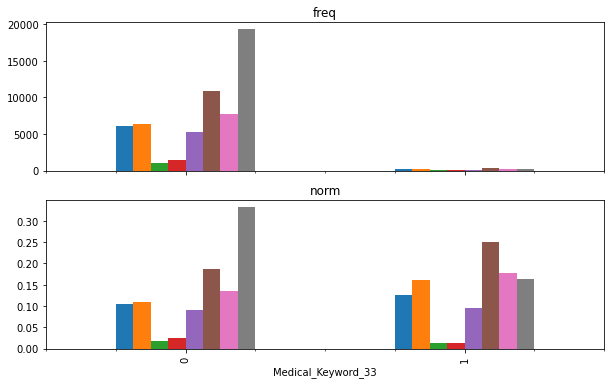

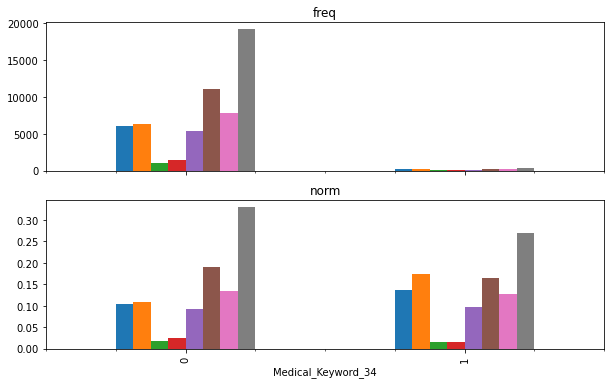

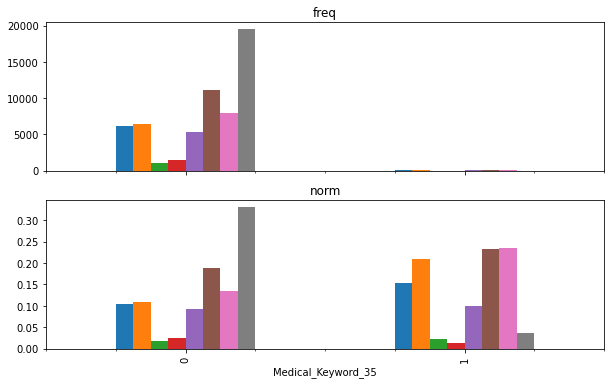

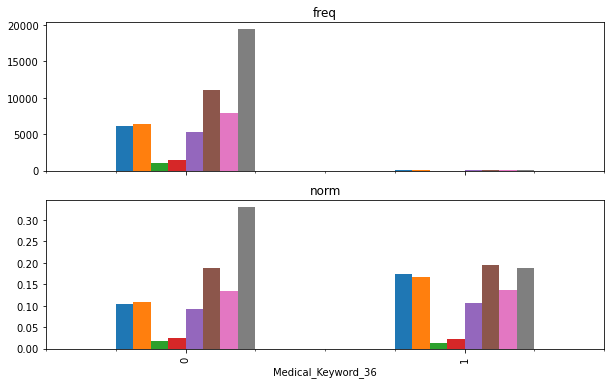

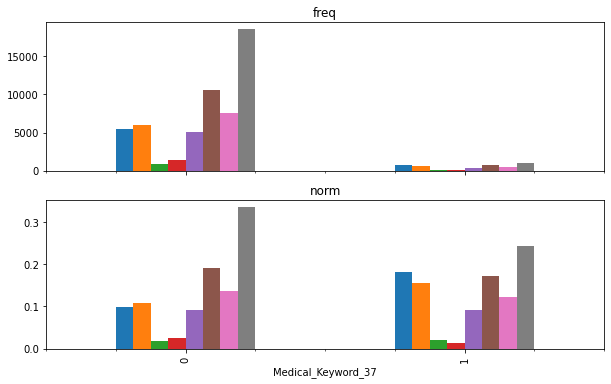

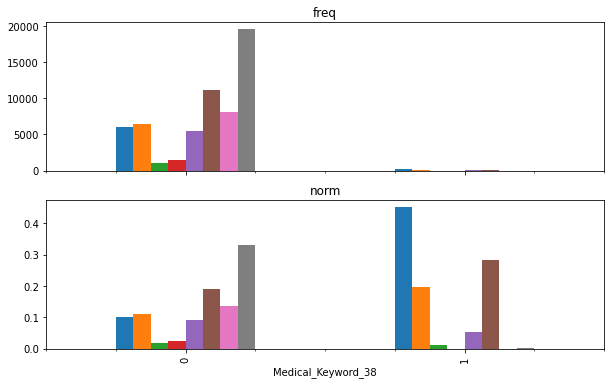

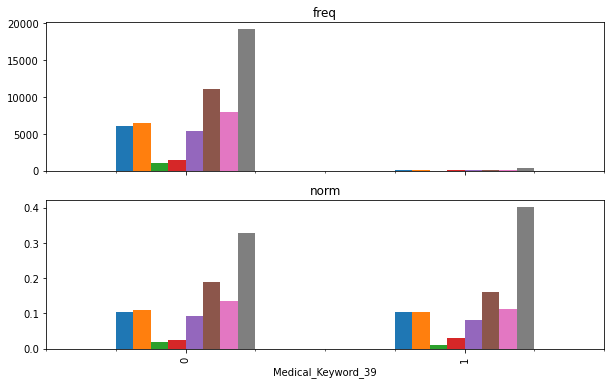

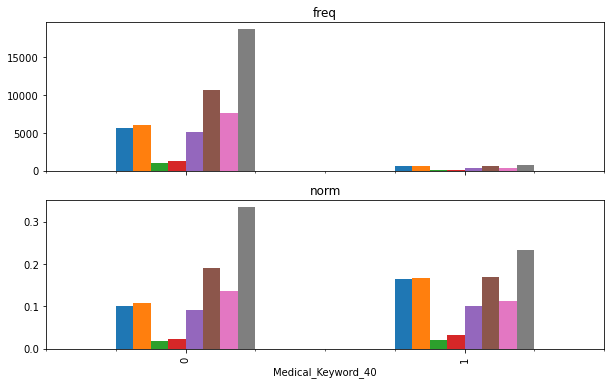

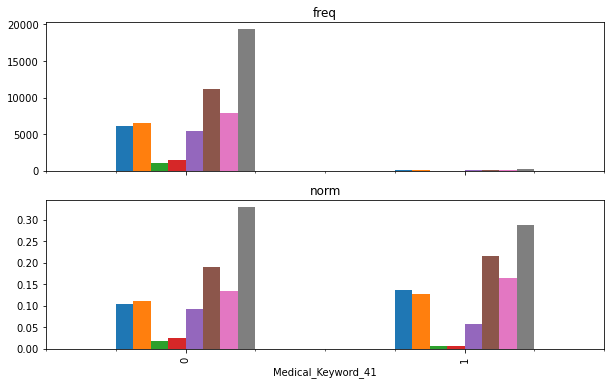

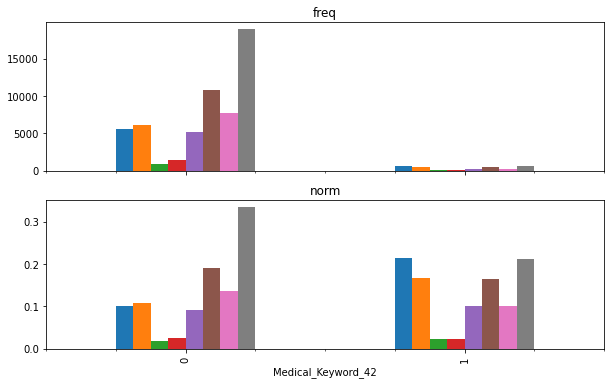

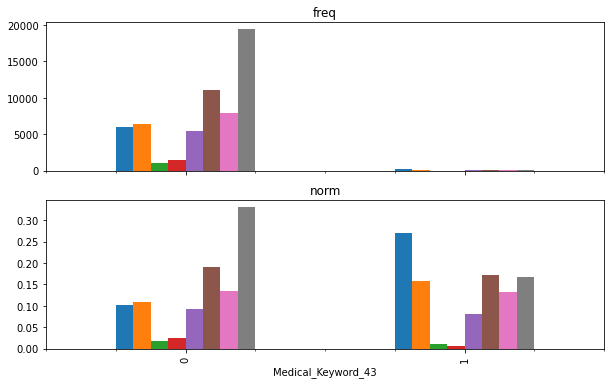

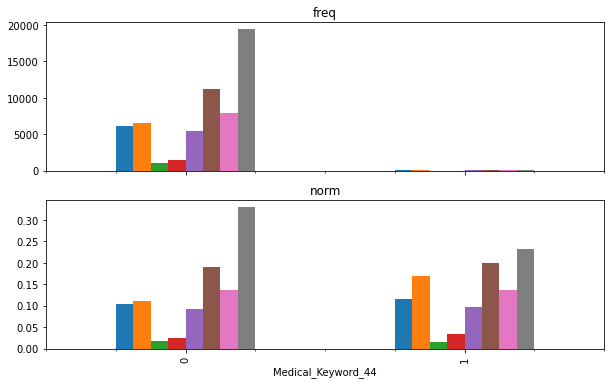

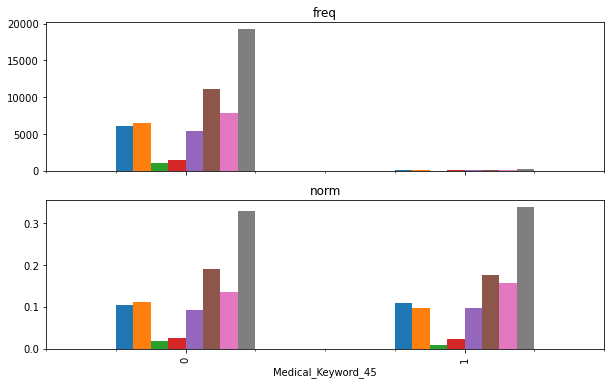

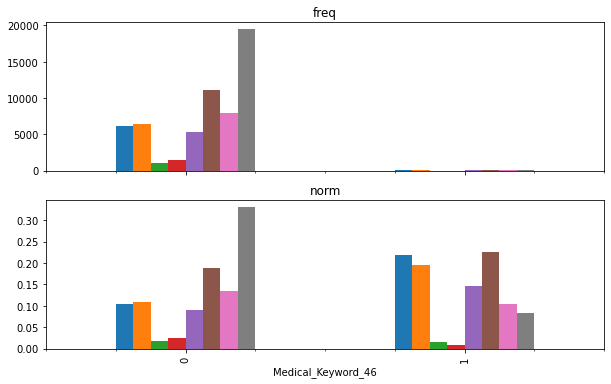

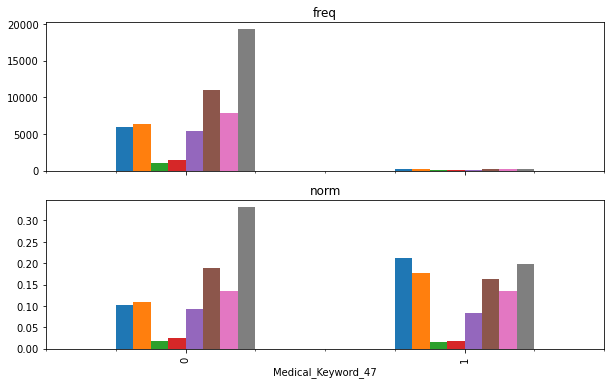

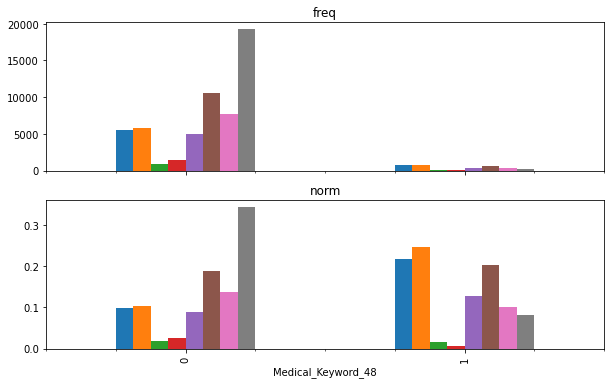

In [67]:
for col in medkey_cols[:-1]:
    group_col_plot(col)

__Medical Keywords__

Scrolling through the 48 columns of Medical Keywords, there is one trend that is common by all of them: Those who are categorized as a False (0) for each of the keywords have nearly identical distributions. This reflects the approximate distribution of the entire dataset.

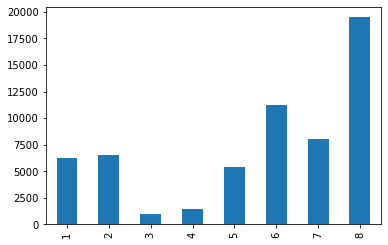

In [68]:
train['Response'].value_counts().sort_index().plot.bar()

Observable differences arise when the keyword counts are True (1). They each differ slightly, but it's undeniable that having a 1 in many of them significantly decreases the probabillity of receiving a response of 8.

There is potential for feature engineering here. One is that we can count the number of 'True's in Medical Keywords.

In [69]:
medkey_features['count'] = medkey_features.sum(axis=1)

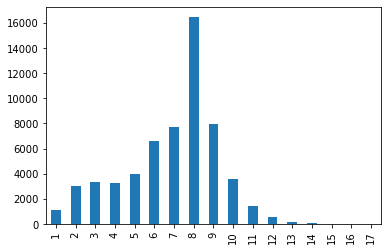

In [70]:
medkey_features['count'].value_counts().sort_index().plot.bar()

In [71]:
medkey_features['count'].value_counts()

8     16471
9      7966
7      7690
6      6617
5      4014
10     3552
3      3325
4      3249
2      3025
11     1442
1      1137
12      566
13      201
14       87
15       29
16        8
17        2
Name: count, dtype: int64

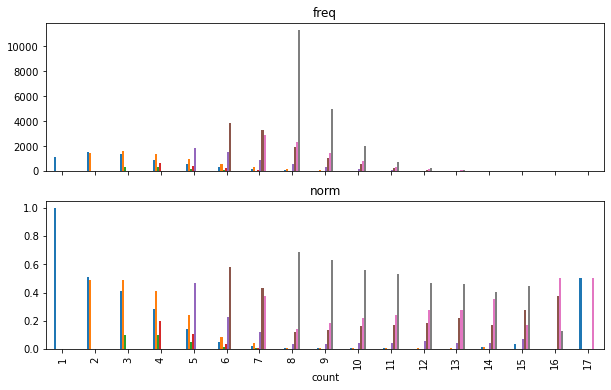

In [72]:
group_col_plot('count', medkey_features)

Interestingly, most of the applications have 8 counts of medical keywords, and incidentally that is where the REsponse of 8 really starts to increase. 

While the individual keywords themselves do not appear to have much predictive power, features that arise from the count of the medical keywords should absolutely be included in the model! At the very least, they would help in distinguishing the majority class (8).

## Continuous Variable Visualization

This is merely an experiment to see whether or not the un-engineered continuous variables by themselves are particularly helpful in drawing boundaries between the data.

In [73]:
# Instantiate PCA 
pca = PCA()

In [74]:
continuous_cols = [
    'Product_Info_3',
'Product_Info_4',
'Ins_Age',
'Ht',
'BMI',
'Employment_Info_1',
'Employment_Info_2',
'Employment_Info_4',
'Employment_Info_6',
'InsuredInfo_3',
'Family_Hist_2',
'Family_Hist_3',
'Family_Hist_4',
'Family_Hist_5',
'Medical_History_2',
'Medical_History_10',
'Medical_History_15',
'Medical_History_24',
'Medical_History_32'
]

In [78]:
train_cont = train[continuous_cols].copy().fillna(0)

In [79]:
train_pca = pca.fit_transform(train_cont)

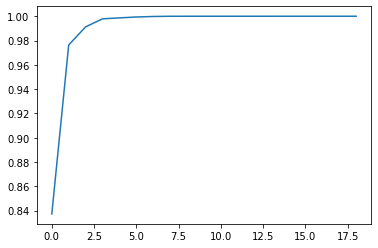

In [80]:
# Most variance within continuous variables are explainable in the first 3 dimensions
pd.Series(pca.explained_variance_ratio_.cumsum()).plot.line()

In [81]:
# Limit to 3 dimensions
pca = PCA(3)

train_cont_pca = pd.DataFrame(pca.fit_transform(train_cont), columns=['pc1', 'pc2', 'pc3'])
train_cont_pca['Response'] = train['Response'].reset_index()['Response'].astype('str')

In [82]:
# Sample 2% of the data
sample = train_cont_pca.groupby('Response').apply(lambda x: x.sample(frac=.02))

In [83]:
sample.shape

(1189, 4)

In [84]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [85]:
sample.iplot(kind='scatter3d', x='pc1', y='pc2', z='pc3', categories='Response')

In [89]:
# Try doing this but with null columns dropped instead of filled with 0
train_cont_nn = train[continuous_cols].copy().dropna(axis=1)
train_cont_nn_pca = pd.DataFrame(pca.fit_transform(train_cont_nn), columns=['pc1', 'pc2', 'pc3'])
train_cont_nn_pca['Response'] = train['Response'].reset_index()['Response'].astype('str')

sample = train_cont_nn_pca.groupby('Response').apply(lambda x: x.sample(frac=.02))
sample.iplot(kind='scatter3d', x='pc1', y='pc2', z='pc3', categories='Response')

As we can see the 3d projection of post-PCA continuous variables is quite disappointing (though filling nulls with 0 may have contributed a lot), it is more likely that missing values are responsibleWhile we can see that the Response 8 points mostly lie along one group, it is impossible to draw boundaries between the classes. We must ensure that we focus on engineering categorical variables.

It may also be necessary to rethink the problem from trying to identify 8 classes to simply identifying 2.

# All Conclusions - For Future Reference

## Product Conclusions 

- Product 1 - Can eliminate
- Product 2 - Consider engineering features from this column or using get_dummies on the whole thing
- Product 3 - Can eliminate 
- Product 4 - Most variability between the 0.2-0.4 region. Consider engineering 
- Product 5 - Can eliminate
- Proudct 6 - Can eliminate 
- Product 7 - Consider engineering a feature for value of '2'. '1' outweighs everything else dramatically, might not be useful.

Overall these columns are generally imbalanced (low predictive power) or have identical distributions within each class/histogram. I suspect these columns have to do with user input preferences. It is possible that user opinion matters very little when it comes to plan selection. 

Overall it is possible that these features could be useful when combined with others. Individually, they don't seem very strong.

## Physical Features Conclusion 

- Ins_Age - May be useful. Unclear since all responses have applicants of all ages 
- Ht - Conventional wisdom says this feature is useless. 
- BMI - Promising feature. Include.

## Employment Information Conclusions 

- Employment_Info_1 - Can eliminate 
- Employment_Info_2 - Very similar distributions. Consider engineering
- Employment_Info_3 - Similar distributions with imbalanced category. Consider engineering, response 1 higher in 3
- Employment_Info_4 - Low variability, can eliminate 
- Employment_Info_5 - Imbalanced with similar distributions. Can eliminate
- Employment_Info_6 - Similar distributions across all classes. Can eliminate.

## MedHist Continuous Variables

- Medical_History_1 - Generally low variability. Most values cluster near the lower end. Imputing might not be a good use of time
- Medical_History_2 - Plenty of variability though distributions among classes are very similar.
- Medical_History_10 - Response 3 and 8 appear uniquely defined, would be good to include. Contains many nulls though. May need to generate features of (notnull AND lower quartiled) and (notnull AND higher quartile) and (null)
- Medical_History_15 - Classes 3/4 look separable. Many nulls. Consider separating along upper/lower quartiles and nulls
- Medical_History_24 - Some degree of correlation observed. Consider separating along upper/lower quartiles and nulls
- Medical_History_32 - Poor distributions. Consider separating along upper/lower quartiles and nulls.

## Medical Keywords

Scrolling through the 48 columns of Medical Keywords, there is one trend that is common by all of them: Those who are categorized as a False (0) for each of the keywords have nearly identical distributions. This reflects the approximate distribution of the entire dataset.